In [104]:
from __future__ import print_function

import numpy as np
import yt
import unyt
from yt.units import *
from yt import YTArray

import argparse
import os
import glob
import sys
from astropy.table import Table
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import random
from scipy import interpolate
from scipy.signal import correlate2d
#from photutils import detect_threshold, detect_sources, source_properties, EllipticalAperture
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.stats import binned_statistic
from scipy.optimize import minimize
import trident
import ast
#import emcee
import numpy.random as rn
from multiprocessing import Pool
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from yt.units import kpc, cm
import cmasher as cmr
from itertools import combinations
from matplotlib.cm import ScalarMappable


# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_refine_box import get_refine_box
from foggie.utils.get_halo_center import get_halo_center
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib as mpl
import h5py
import matplotlib.cm as mtcm
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

from foggie.clumps.clump_finder.utils_diskproject import load_disk 
from collections import defaultdict
import pandas as pd
import math
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


from foggie.clumps.clump_finder.utils_clump_finder import *
from foggie.clumps.clump_finder.clump_finder_argparser import *
from foggie.clumps.clump_finder.fill_topology import *
from foggie.clumps.clump_finder.clump_load import *
from foggie.clumps.clump_finder.clump_finder import clump_finder



In [105]:
def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot


run = 'nref11c_nref9f'#'ludicrous/nref11c_nref9f.enhance'

ions = ['HI','OVI', 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII'] 
orientations = ['face','edge']
regions = ['all','cgm'] 
cmap = mtcm.get_cmap('Set1', len(ions))  

box_name = '100'
output = 'RD0032'
snap = output
resolutions = [0.27,1,3,6]
if snap == 'RD0042':
    halos = ['2392','4123','5016','5036','8508']
    z = '0.0'
elif snap == 'RD0040':
    halos = ['2878','2392','4123','5016','5036','8508']
    z = '0.1'
elif snap == 'RD0032':
    halos = ['2878']#['2878','2392','4123','5016','5036','8508']
    z = '0.5'

    

/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_53724/3598442098.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('Set1', len(ions))


Figure 7

In [ ]:
##################################### Figure 7: LOS velocity maps for all ions #####################################
from matplotlib.patches import Circle
orientations = ['edge']
for orientation in orientations:
    for region in regions:
        print(f"Orientation: {orientation}, region: {region}")
        for halo in halos:
            halo_name = halo_dict[halo]
            foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)

            if region == 'all':
                prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolutions[0]))
            elif region == 'cgm':
                prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolutions[0]), 'disk_cgm')
            elif region in ['inflow', 'outflow']:
                prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'inflow_outflow')

            save_path = os.path.join(prefix, 'FRBs')
            file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

            if not os.path.isfile(file_path):
                print(f"Missing {file_path}")
                continue

            with h5py.File(file_path, 'r') as f:
                zgroup = list(f.keys())[0]
                grp = f[zgroup]

                width_value = grp.attrs["image_extent_kpc"]
                round_bin_size_kpc = grp.attrs["FRB_pixel_size_kpc"]
                res = int(width_value / round_bin_size_kpc)

                fig, axes = plt.subplots(4, 2, figsize=(8, 16), sharex=True, sharey=True)
                plt.subplots_adjust(wspace=0.0, hspace=0.0)
                axes = axes.flatten()

                if region == 'cgm':
                    try:
                        snap_name = foggie_dir + '/' + snap + '/' + snap  
                        ds,refine_box = foggie_load(snap_name, trackname, do_filter_particles=True, halo_c_v_name=halo_c_v_name, disk_relative=True, correct_bulk_velocity=True)
                        print('output_dir:', output_dir)
                        disk_file = output_dir + 'plots_halo_00' + halo + '/' + run +  '/FOGGIE' + '/'+ output + '/'+ '/Disk/H1_Disk.h5'
        
                        disk_cut = load_clump(ds, disk_file, source_cut=refine_box)
                        proj_disk = yt.ProjectionPlot(ds, ds.x_unit_disk if orientation == 'edge' else ds.z_unit_disk,
                                                        ('gas', 'H_p0_number_density'),
                                                        center=ds.halo_center_kpc, data_source=disk_cut,
                                                        width=(100, 'kpc'),
                                                        north_vector=ds.z_unit_disk if orientation == 'edge' else ds.x_unit_disk,
                                                        buff_size=[res, res],weight_field=None)
                        disk_frb = proj_disk.frb[('gas', 'H_p0_number_density')].v
                        #ax_hi.contour(disk_frb, levels=4, colors='white', linewidths=0.8)
                    except Exception as e:
                        print(f"Could not overlay disk contours on HI: {e}")

                im = None
                mymap = cmr.get_sub_cmap('cmr.viola', 0.1, 0.9)
                for i, ion in enumerate(ions):
                    vel_key = f"{ion}_vlos_emissweighted_{orientation}_{region}"
                    x_key = f"{ion}_x_{orientation}_{region}"
                    y_key = f"{ion}_y_{orientation}_{region}"

                    if vel_key not in grp:
                        print(f"Missing {vel_key}")
                        continue

                    vlos_map = np.array(grp[vel_key])
                    x_coords = np.array(grp[x_key])
                    y_coords = np.array(grp[y_key])

                    ax = axes[i]
                    im = ax.imshow(
                        vlos_map,
                        origin='lower',
                        extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                        cmap=mymap,
                        vmin=-300, vmax=300
                    )

                    

                    # === Disk indicator parameters ===
                    R_DISK = 2   # radius of the disk in kpc
                    LINE_Y = 0     # draw through the midplane (y = 0)
                    LINE_EXTENT = 10  # half width of the box (50 kpc each side)

                    # center coordinates (assuming map centered at 0)
                    cx, cy = 0, 0

                    # --- draw circle for the disk ---
                    circ = Circle((cx, cy), R_DISK, fill=True, facecolor='dimgrey',
                                edgecolor='dimgrey', linewidth=2.0, linestyle='-', zorder=5)
                    ax.add_patch(circ)

                    # --- draw horizontal guide lines (disk plane) ---
                    ax.hlines(y=LINE_Y, xmin=-LINE_EXTENT, xmax=-R_DISK,
                            colors='dimgrey', linestyles='-', linewidth=3.0, zorder=5)
                    ax.hlines(y=LINE_Y, xmin=R_DISK, xmax=LINE_EXTENT,
                            colors='dimgrey', linestyles='-', linewidth=3.0, zorder=5)


                    # if region == 'cgm':
                    #         try:
                    #             ax.contour(disk_frb, levels=5, colors='gray', linewidths=0.8)
                    #         except Exception as e:
                    #             print(f"Could not overlay disk contours on {ion}: {e}")

                    ax.set_xticks([])
                    ax.set_yticks([])

                    # Add 10 kpc scale bar to the FIRST subplot only
                    if i == 0:
                        scalebar_length = 10  # in kpc
                        x0 = x_coords.min() + 0.05 * (x_coords.max() - x_coords.min())
                        y0 = y_coords.min() + 0.05 * (y_coords.max() - y_coords.min())
                        ax.plot([x0, x0 + scalebar_length], [y0, y0], color='k', lw=2)
                        ax.text(x0 + scalebar_length / 2, y0 + 0.01 * (y_coords.max() - y_coords.min()),
                                '10 kpc', color='k', ha='center', va='bottom', fontsize=11)
                        
                    # Ion name as legend inside subplot
                    if ion == 'HI':
                            ax.text(0.05, 0.90, r'H$\alpha$', transform=ax.transAxes, fontsize=16, color='k', weight='bold', va='top', ha='left')
                    else:
                        ax.text(0.05, 0.90, ion, transform=ax.transAxes, fontsize=16, color='k', weight='bold', va='top', ha='left')



                # Remove unused axes
                for j in range(len(ions), len(axes)):
                    fig.delaxes(axes[j])

                # Add horizontal colorbar at the bottom
                cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.015])
                cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
                cbar.set_label('Emissivity Weighted LOS Velocity [km/s]', fontsize=14)

                # Tight layout & adjustments
                #plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.07, right=0.93, top=0.95, bottom=0.12)
                #fig.suptitle(f'Halo {halo_name} - {orientation} - {region}', fontsize=16)

                output_path = output_dir + '/All_halos/velocity_projections_grid'
                os.makedirs(output_path, exist_ok=True)
                output_file = os.path.join(output_path, f'{region}_{halo_name}_LOSvelosity_{orientation}_{snap}.png')
                plt.savefig(output_file, dpi=300, bbox_inches='tight')
                plt.show()
                plt.close()



Figure 8

In [ ]:
##################################### Figure 8 - top: comparing los velocity maps for HI and OVI, CIII, MgII #####################################
##################################### Figure 8 - bottom: is made with plot_3x3_velocity_comparison_grid function in kinematics.py ##############
import pandas as pd

mpl.rcParams.update({
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "xtick.color": "black",
    "ytick.color": "black",
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
})

# Initialize storage for resolved fractions
results = []
ions = ['OVI', 'CIII', 'MgII']
spectral_resolutions = [200, 100, 30]
base_cmap = cmr.get_sub_cmap('cmr.viola', 0.1, 0.9)
regions = ['cgm']#['all','cgm']
orientations = ['face','edge']
#
resolutions = [0.27]#,1,3,6]
halos = ['2878','2392','4123','5016','5036','8508']

target_positions =[
                    (yt.YTQuantity(4.00, "kpc"), yt.YTQuantity(25.0, "kpc")),
                    (yt.YTQuantity(28.1, "kpc"), yt.YTQuantity(24.1, "kpc")),
                    (yt.YTQuantity(-30.0, "kpc"), yt.YTQuantity(5.0, "kpc"))
                ]

for resolution in resolutions:
    for orientation in orientations:
        for halo in halos:
            halo_name = halo_dict[halo]
            print(halo_name)
            for region in regions:
                foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)

                if region == 'all':
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                        f'box_{box_name}', 'with_disk', str(resolution))
                elif region == 'cgm':
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                        f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')
                else:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                        f'box_{box_name}', 'inflow_outflow')

                save_path = os.path.join(prefix, 'FRBs')
                file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")
                print('file path',file_path)
                if not os.path.isfile(file_path):
                    print(f"Missing {file_path}")
                    continue

                with h5py.File(file_path, 'r') as f:
                    zgroup = list(f.keys())[0]
                    grp = f[zgroup]

                    try:
                        v_HI = np.array(grp[f"HI_vlos_emissweighted_{orientation}_{region}"])
                        x_coords = np.array(grp[f"HI_x_{orientation}_{region}"])
                        y_coords = np.array(grp[f"HI_y_{orientation}_{region}"])
                    except KeyError:
                        print(f"Missing HI data for {halo_name}")
                        continue

                    fig, axes = plt.subplots(3, 3, figsize=(15, 16))
                    plt.subplots_adjust(wspace=0.01, hspace=0.0)

                    # Loop over ions and resolutions
                    for i, ion in enumerate(ions):
                        try:
                            v_ion = np.array(grp[f"{ion}_vlos_emissweighted_{orientation}_{region}"])
                        except KeyError:
                            print(f"Missing {ion} data for {halo_name}")
                            continue

                        delta_v_map = np.abs(v_HI - v_ion)
                        

                        for j, res in enumerate(spectral_resolutions):
                            ax = axes[i, j]
                            ax.set_xticks([])
                            ax.set_yticks([])

                            resolved = np.sum(delta_v_map >= res)
                            total_valid_pixels = np.sum(np.isfinite(delta_v_map))
                            fraction = resolved / total_valid_pixels
                            print(res,fraction*100)

                            ax.text(0.03, 0.92, f'{fraction*100:.1f}%', transform=ax.transAxes,
                            fontsize=18, fontweight='bold', color='white',
                            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

                            results.append({
                                            'Halo': halo_name,
                                            'Region': region,
                                            'Ion': ion,
                                            'SpectralRes_kms': res,
                                            'ResolvedFraction': fraction,
                                            'Orientation': orientation,
                                            'SpatialRes_kpc': resolution
                                        })



                            

                            # Create split colormap
                            spectral_resolution = res
                            vmin, vmax = 0, 300
                            norm = Normalize(vmin=vmin, vmax=vmax)
                            frac_below = (res - vmin) / (vmax - vmin)
                            below_n = int(frac_below * 100)
                            above_n = 100 - below_n

                            # cmap4 = cmr.take_cmap_colors('cmr.neutral_r', below_n, cmap_range=(0.1, 0.6), return_fmt='rgba')
                            # cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.0, 0.9), return_fmt='rgba')
                            # combined_colors = cmap4 + cmap1
                            # mymap = mcolors.LinearSegmentedColormap.from_list('splitcmap', combined_colors)

                            cmap4 = cmr.take_cmap_colors('cmr.neutral_r', below_n, cmap_range=(0.1, 0.6), return_fmt='rgba')
                            if spectral_resolution == 200:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.55, 0.9), return_fmt='rgba')
                            elif spectral_resolution == 100:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.15, 0.9), return_fmt='rgba')
                            elif spectral_resolution == 30:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.0, 0.9), return_fmt='rgba')
                            else:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.3, 0.9), return_fmt='rgba')

                            combined_colors = cmap4 + cmap1
                            mymap = mcolors.LinearSegmentedColormap.from_list('splitcmap', combined_colors)

                            im = ax.imshow(delta_v_map, origin='lower',
                                        extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                                        cmap=mymap, vmin=vmin, vmax=vmax)
                            
                            #for (y_kpc, z_kpc) in target_positions[:1]:
                            y_kpc, z_kpc = target_positions[i]
                            ax.plot(y_kpc, z_kpc, marker='s', markersize=10, markerfacecolor='none',
                                        markeredgecolor='lime', markeredgewidth=2.5)

                            # Add shared colorbar only to first row
                            if i == 0:
                                # Custom shifts and scaling per column
                                x_shifts = [0.02, 0.02, 0.02]  # Tune these individually
                                width_scales = [0.8, 0.8, 0.8]  # Adjust width per column if needed
                                y_shift = 0.01  # Constant vertical lift for all
                                height = 0.015   # Height of colorbar

                                if i == 0:  # Only apply colorbar once per column (top row)
                                    bbox = axes[0, j].get_position()
                                    x0 = bbox.x0 + x_shifts[j]
                                    y1 = bbox.y1 + y_shift
                                    width = bbox.width * width_scales[j]

                                    cbar_ax = fig.add_axes([x0, y1, width, height])
                                    cbar = fig.colorbar(
                                        ScalarMappable(norm=norm, cmap=mymap),
                                        cax=cbar_ax, orientation='horizontal'
                                    )
                                    cbar.ax.tick_params(labelsize=16, direction='out')
                                    cbar.ax.xaxis.set_label_position('top')
                                    cbar.ax.xaxis.set_ticks_position('top')
                                    cbar.set_label(f'$\Delta$v [km/s]', fontsize=22)

                            if j == 0:
                                ax.set_ylabel(f'HI & {ion}', fontsize=22)


                output_path = output_dir + '/All_halos/velocity_diff_grid'
                os.makedirs(output_path, exist_ok=True)
                output_file = os.path.join(output_path, f'{region}_{halo_name}_LOSvDiff_{orientation}_{snap}_{resolution}.png')
                plt.savefig(output_file, dpi=300, bbox_inches='tight')
                plt.show()
                plt.close()

                    
# Convert to pandas DataFrame
df = pd.DataFrame(results)

# Compute averages across halos
df_avg = df.groupby(['Ion', 'SpectralRes_kms'])['ResolvedFraction'].agg(['mean', 'std']).reset_index()
df_avg.rename(columns={'mean': 'MeanFraction', 'std': 'StdDev'}, inplace=True)

# Save both tables
output_table_dir = os.path.join(output_dir, 'All_halos/velocity_diff_grid')
os.makedirs(output_table_dir, exist_ok=True)
df.to_csv(os.path.join(output_table_dir, 'resolved_fractions_per_halo.csv'), index=False)
df_avg.to_csv(os.path.join(output_table_dir, 'resolved_fractions_avg.csv'), index=False)

# Optionally display
#import ace_tools as tools; tools.display_dataframe_to_user("Resolved Fractions Per Halo", df)



Figure 9

In [ ]:
# csv for figure 9 with more data points
# Initialize storage for resolved fractions
results = []
ions = ['OVI', 'CIII', 'MgII']
spectral_resolutions = [300, 200, 150, 100, 60, 30, 15, 10, 5]
base_cmap = cmr.get_sub_cmap('cmr.viola', 0.1, 0.9)
regions = ['cgm']#['all','cgm']
orientations = ['face','edge']
#
resolutions = [0.27]#,1,3,6]
halos = ['2878','2392','4123','5016','5036','8508']

target_positions =[
                    (yt.YTQuantity(4.00, "kpc"), yt.YTQuantity(25.0, "kpc")),
                    (yt.YTQuantity(28.1, "kpc"), yt.YTQuantity(24.1, "kpc")),
                    (yt.YTQuantity(-30.0, "kpc"), yt.YTQuantity(5.0, "kpc"))
                ]

for resolution in resolutions:
    for orientation in orientations:
        for halo in halos:
            halo_name = halo_dict[halo]
            print(halo_name)
            for region in regions:
                foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)

                if region == 'all':
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                        f'box_{box_name}', 'with_disk', str(resolution))
                elif region == 'cgm':
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                        f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')
                else:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                        f'box_{box_name}', 'inflow_outflow')

                save_path = os.path.join(prefix, 'FRBs')
                file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")
                print('file path',file_path)
                if not os.path.isfile(file_path):
                    print(f"Missing {file_path}")
                    continue

                with h5py.File(file_path, 'r') as f:
                    zgroup = list(f.keys())[0]
                    grp = f[zgroup]

                    try:
                        v_HI = np.array(grp[f"HI_vlos_emissweighted_{orientation}_{region}"])
                        x_coords = np.array(grp[f"HI_x_{orientation}_{region}"])
                        y_coords = np.array(grp[f"HI_y_{orientation}_{region}"])
                        ncols = len(spectral_resolutions)
                    except KeyError:
                        print(f"Missing HI data for {halo_name}")
                        continue

                    fig, axes = plt.subplots(3, ncols, figsize=(5*ncols, 16))
                    plt.subplots_adjust(wspace=0.01, hspace=0.0)

                    # Loop over ions and resolutions
                    for i, ion in enumerate(ions):
                        try:
                            v_ion = np.array(grp[f"{ion}_vlos_emissweighted_{orientation}_{region}"])
                        except KeyError:
                            print(f"Missing {ion} data for {halo_name}")
                            continue

                        delta_v_map = np.abs(v_HI - v_ion)
                        

                        for j, res in enumerate(spectral_resolutions):
                            ax = axes[i, j]
                            ax.set_xticks([])
                            ax.set_yticks([])

                            resolved = np.sum(delta_v_map >= res)
                            total_valid_pixels = np.sum(np.isfinite(delta_v_map))
                            fraction = resolved / total_valid_pixels
                            print(res,fraction*100)

                            ax.text(0.03, 0.92, f'{fraction*100:.1f}%', transform=ax.transAxes,
                            fontsize=14, fontweight='bold', color='white',
                            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

                            results.append({
                                            'Halo': halo_name,
                                            'Region': region,
                                            'Ion': ion,
                                            'SpectralRes_kms': res,
                                            'ResolvedFraction': fraction,
                                            'Orientation': orientation,
                                            'SpatialRes_kpc': resolution
                                        })



                            

                            # Create split colormap
                            spectral_resolution = res
                            vmin, vmax = 0, 300
                            norm = Normalize(vmin=vmin, vmax=vmax)
                            frac_below = (res - vmin) / (vmax - vmin)
                            below_n = int(frac_below * 100)
                            above_n = 100 - below_n

                            # cmap4 = cmr.take_cmap_colors('cmr.neutral_r', below_n, cmap_range=(0.1, 0.6), return_fmt='rgba')
                            # cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.0, 0.9), return_fmt='rgba')
                            # combined_colors = cmap4 + cmap1
                            # mymap = mcolors.LinearSegmentedColormap.from_list('splitcmap', combined_colors)

                            cmap4 = cmr.take_cmap_colors('cmr.neutral_r', below_n, cmap_range=(0.1, 0.6), return_fmt='rgba')
                            if spectral_resolution == 200:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.55, 0.9), return_fmt='rgba')
                            elif spectral_resolution == 100:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.15, 0.9), return_fmt='rgba')
                            elif spectral_resolution == 30:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.0, 0.9), return_fmt='rgba')
                            else:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.3, 0.9), return_fmt='rgba')

                            combined_colors = cmap4 + cmap1
                            mymap = mcolors.LinearSegmentedColormap.from_list('splitcmap', combined_colors)

                            im = ax.imshow(delta_v_map, origin='lower',
                                        extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                                        cmap=mymap, vmin=vmin, vmax=vmax)
                            
                            #for (y_kpc, z_kpc) in target_positions[:1]:
                            y_kpc, z_kpc = target_positions[i]
                            ax.plot(y_kpc, z_kpc, marker='s', markersize=10, markerfacecolor='none',
                                        markeredgecolor='lime', markeredgewidth=2.5)

                            # Add shared colorbar only to first row
                            if i == 0:
                                # Custom shifts and scaling per column
                                x_shifts = [0.02, 0.02, 0.02,0.02, 0.02, 0.02,0.02, 0.02, 0.02]  # Tune these individually
                                width_scales = [0.8, 0.8, 0.8,0.8, 0.8, 0.8,0.8, 0.8, 0.8]  # Adjust width per column if needed
                                y_shift = 0.01  # Constant vertical lift for all
                                height = 0.015   # Height of colorbar

                                if i == 0:  # Only apply colorbar once per column (top row)
                                    bbox = axes[0, j].get_position()
                                    x0 = bbox.x0 + x_shifts[j]
                                    y1 = bbox.y1 + y_shift
                                    width = bbox.width * width_scales[j]

                                    cbar_ax = fig.add_axes([x0, y1, width, height])
                                    cbar = fig.colorbar(
                                        ScalarMappable(norm=norm, cmap=mymap),
                                        cax=cbar_ax, orientation='horizontal'
                                    )
                                    cbar.ax.tick_params(labelsize=14, direction='out')
                                    cbar.ax.xaxis.set_label_position('top')
                                    cbar.ax.xaxis.set_ticks_position('top')
                                    cbar.set_label(f'$\Delta$v [km/s]', fontsize=18)

                            if j == 0:
                                ax.set_ylabel(f'HI & {ion}', fontsize=20)


                output_path = output_dir + '/All_halos/velocity_diff_grid'
                os.makedirs(output_path, exist_ok=True)
                output_file = os.path.join(output_path, f'{region}_{halo_name}_LOSvDiff_{orientation}_{snap}_{resolution}.png')
                #plt.savefig(output_file, dpi=300, bbox_inches='tight')
                #plt.show()
                plt.close()

                    
# Convert to pandas DataFrame
df = pd.DataFrame(results)

# Compute averages across halos
df_avg = df.groupby(['Ion', 'SpectralRes_kms'])['ResolvedFraction'].agg(['mean', 'std']).reset_index()
df_avg.rename(columns={'mean': 'MeanFraction', 'std': 'StdDev'}, inplace=True)

# Save both tables
output_table_dir = os.path.join(output_dir, 'All_halos/velocity_diff_grid')
os.makedirs(output_table_dir, exist_ok=True)
df.to_csv(os.path.join(output_table_dir, 'resolved_fractions_per_halo_morepoints.csv'), index=False)
df_avg.to_csv(os.path.join(output_table_dir, 'resolved_fractions_avg.csv'), index=False)

# Optionally display
#import ace_tools as tools; tools.display_dataframe_to_user("Resolved Fractions Per Halo", df)



Saving plot to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/velocity_diff_grid/resolved_fraction_per_ion_vs_res.pdf


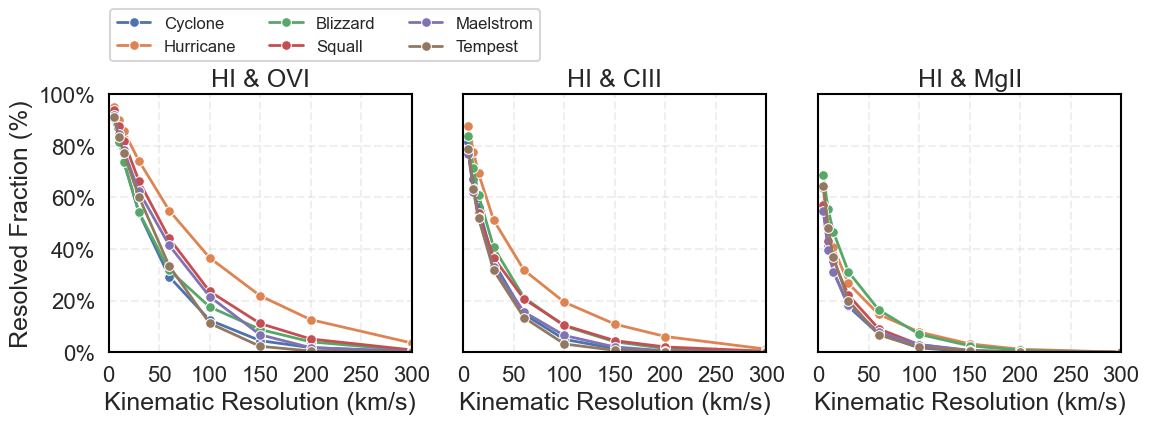

In [95]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

csv_path = os.path.join(output_dir, 'All_halos', 'velocity_diff_grid', 'resolved_fractions_per_halo_morepoints.csv')


df = pd.read_csv(csv_path)
df["ResolvedFraction (%)"] = (df["ResolvedFraction"] * 100).round(1)


output_table_dir = os.path.join(output_dir, 'All_halos', 'velocity_diff_grid')
os.makedirs(output_table_dir, exist_ok=True)


sns.set(style="whitegrid", context="talk", font_scale=1)
palette = sns.color_palette("Set2")

g2 = sns.FacetGrid(df, col="Ion", col_wrap=3, height=4, sharey=True)

g2.map_dataframe(
    sns.lineplot,
    x="SpectralRes_kms",
    y="ResolvedFraction (%)",
    hue="Halo",
    linewidth=2,
    errorbar=None,
    marker = 'o', markersize=7)

g2.set_axis_labels("Kinematic Resolution (km/s)", "Resolved Fraction (%)")
g2.set_titles("HI & {col_name}")


for ax in g2.axes.flat:
   
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylim(0, 100)
    
    
    ax.set_xticks([0, 50, 100, 150, 200, 250, 300])
    ax.set_xlim(0, 300)

    
    ax.tick_params(axis='both', which='major', labelsize=16, width=1.8, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=14, width=1.2, length=4)

    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_color("black")

    # Keep grid soft and behind the data
    ax.grid(True, linestyle='--', alpha=0.3, zorder=-1)



g2.add_legend(loc='upper center', bbox_to_anchor=(0.21, 1.1),
              ncol=3, frameon=True,fontsize=12)
plt.subplots_adjust(top=0.90)
g2.tight_layout()


plot2_path = os.path.join(output_table_dir, "resolved_fraction_per_ion_vs_res.pdf")
print(f"Saving plot to {plot2_path}")
g2.savefig(plot2_path, bbox_inches='tight')
plt.show()
plt.close(g2.fig)


Figure 8

In [ ]:
#####################################  Figure 8: OVI inflow and outflow camparison ###################################

###### Grid of maps for inflow and outflow velocities ######
ions = ['OVI']#, 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII']
spectral_resolutions = [300, 200, 100, 30]
base_cmap = cmr.get_sub_cmap('cmr.viola', 0.1, 0.9)
halos = ['5036']
for resolution in resolutions:
    for orientation in orientations:
        for halo in halos:
            halo_name = halo_dict[halo]
            foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)
            prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'inflow_outflow')
            save_path = os.path.join(prefix,str(resolution), 'FRBs')
            file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

            if not os.path.isfile(file_path):
                print(f"Missing {file_path}")
                continue

            with h5py.File(file_path, 'r') as f:
                zgroup = list(f.keys())[0]
                grp = f[zgroup]

                for ion in ions:
                    try:
                        v_in = np.array(grp[f"{ion}_vlos_emissweighted_{orientation}_inflow"])
                        v_out = np.array(grp[f"{ion}_vlos_emissweighted_{orientation}_outflow"])
                        x_coords = np.array(grp[f"{ion}_x_{orientation}_inflow"])
                        y_coords = np.array(grp[f"{ion}_y_{orientation}_inflow"])
                    except KeyError:
                        print(f"Missing data for {ion} in {halo_name}")
                        continue


                    # Treat zero as invalid (i.e., no emissivity-weighted inflow/outflow)
                    valid_mask = (v_in != 0) & (v_out != 0)
                    delta_v_map = np.full_like(v_in, np.nan)
                    delta_v_map[valid_mask] = np.abs(v_in[valid_mask] - v_out[valid_mask])


                    fig, axes = plt.subplots(3, 2, figsize=(9, 11))
                    plt.subplots_adjust(wspace=0.2, hspace=0.0)
                    axes = axes.flatten()

                    for subplot_index in range(6):
                        ax = axes[subplot_index]
                        ax.set_xticks([])
                        ax.set_yticks([])

                        if subplot_index == 0:
                            im = ax.imshow(v_in, origin='lower',
                                        extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                                        cmap=base_cmap, vmin=-300, vmax=300)
                            colorbar_label = 'v$_{los}$ [km/s] (inflow)'

                        elif subplot_index == 1:
                            im = ax.imshow(v_out, origin='lower',
                                        extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                                        cmap=base_cmap, vmin=-300, vmax=300)
                            colorbar_label = 'v$_{los}$ [km/s] (outflow)'

                        else:
                            res = spectral_resolutions[subplot_index - 2]
                            vmin, vmax = 0, 500
                            norm = Normalize(vmin=vmin, vmax=vmax)
                            frac_below = (res - vmin) / (vmax - vmin)
                            below_n = int(frac_below * 100)
                            above_n = 100 - below_n

                            cmap4 = cmr.take_cmap_colors('cmr.neutral_r', below_n, cmap_range=(0.1, 0.6), return_fmt='rgba')
                            if res == 300:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.75, 0.9), return_fmt='rgba')
                            elif res == 200:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.55, 0.9), return_fmt='rgba')
                            elif res == 100:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.15, 0.9), return_fmt='rgba')
                            elif res == 30:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.0, 0.9), return_fmt='rgba')
                            else:
                                cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.3, 0.9), return_fmt='rgba')

                            combined_colors = cmap4 + cmap1
                            mymap = mcolors.LinearSegmentedColormap.from_list('splitcmap', combined_colors)

                            im = ax.imshow(delta_v_map, origin='lower',
                                        extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
                                        cmap=mymap, vmin=vmin, vmax=vmax)
                            colorbar_label = '|v$_{in}$ - v$_{out}$| [km/s]'

                        # Place colorbar on top of subplot
                        # Place colorbar on the right side of each subplot
                        cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap),
                                            ax=ax, orientation='vertical', pad=0.02, shrink=0.75)
                        cbar.set_label(colorbar_label, fontsize=14)
                        cbar.ax.tick_params(labelsize=12)


                        # cbar.set_label(colorbar_label, fontsize=11)
                        # cbar.ax.xaxis.set_ticks_position('bottom')
                        # cbar.ax.xaxis.set_label_position('bottom')



                    #fig.suptitle(f'{ion} - Halo {halo_name} - {orientation}-on view', fontsize=16)
                    #plt.subplots_adjust(wspace=0.1, hspace=0.3, left=0.05, right=0.95, bottom=0.05, top=0.93)

                    out_dir = os.path.join(output_dir, 'All_halos', 'combined_vlos_dv_maps', f'z={z}', orientation)
                    os.makedirs(out_dir, exist_ok=True)
                    out_file = os.path.join(out_dir, f'{halo_name}_{ion}_{orientation}_combined.png')
                    plt.savefig(out_file, dpi=300, bbox_inches='tight')
                    plt.show()
                    plt.close()


Figure 10

In [2]:
# the bottom left panel including velocity profile of 3 sightlines is made with velocityprofile.py code in notebook directory

Figure 12

/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_53724/4003508499.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20').colors  # 20 colors


Orientation: face


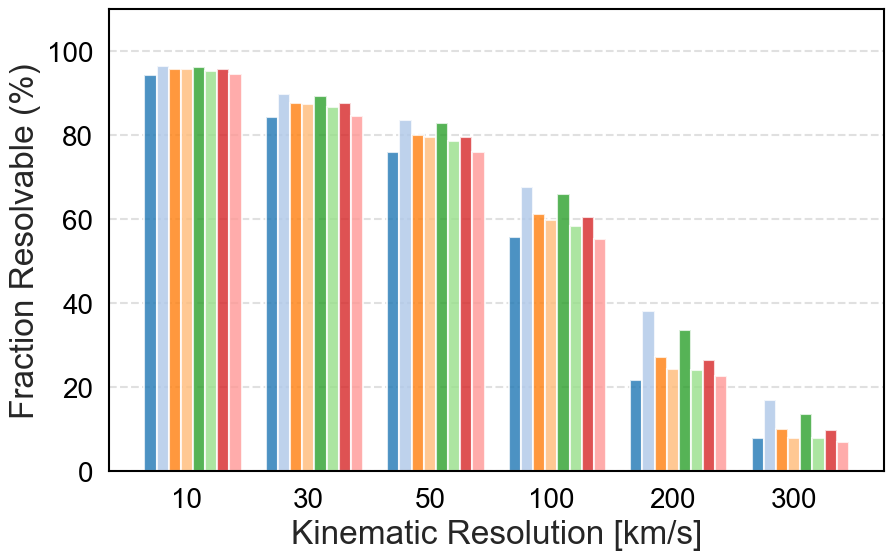

Orientation: edge


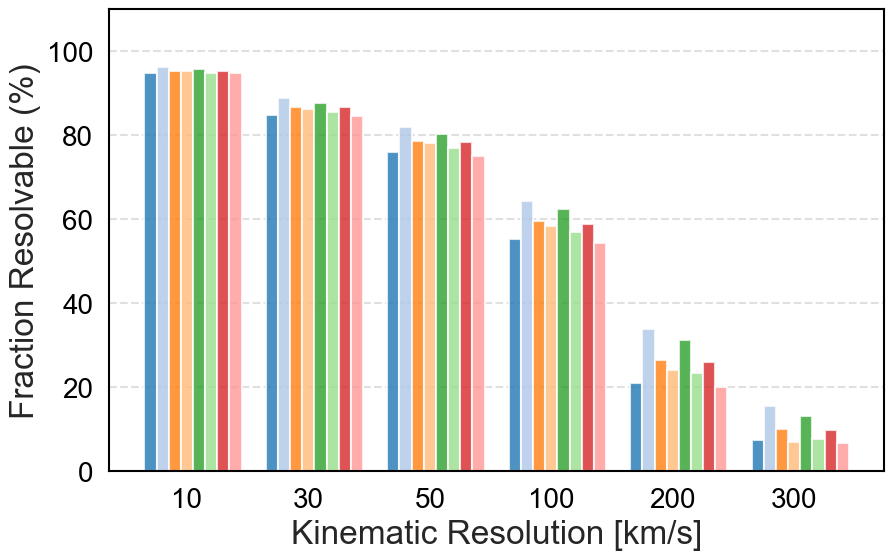

In [137]:
#####################################  Figure 12 version 01: bar chart of spectral resolution and fraction of area that is observable ###################################
from matplotlib import cm
ions = ['HI', 'MgII', 'SiII','CIII', 'SiIII','CIV', 'SiIV','OVI'] 
spectral_resolutions = [10, 30, 50, 100, 200, 300]
halos = ['2878']#,'2392','4123','5016','5036','8508']
resolution = '0.27'  # This is the resolution used in the FOGGIE simulations
colors = cm.get_cmap('tab20').colors  # 20 colors
# regions = ['inflow', 'outflow']  # not used here but kept for completeness

# To store fractions per ion and spectral resolution across all halos
resolvable_fractions = {ion: {res: [] for res in spectral_resolutions} for ion in ions}

for orientation in orientations:
    print(f"Orientation: {orientation}")
    for halo in halos:
        halo_name = halo_dict[halo]
        foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)

        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                              f'box_{box_name}', 'inflow_outflow')

        save_path = os.path.join(prefix, resolution,'inflow_outflow', 'FRBs')
        file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

        if not os.path.isfile(file_path):
            print(f"Missing {file_path}")
            continue

        with h5py.File(file_path, 'r') as f:
            zgroup = list(f.keys())[0]
            grp = f[zgroup]

            for ion in ions:
                try:
                    v_in = np.array(grp[f"{ion}_vlos_emissweighted_{orientation}_inflow"])
                    v_out = np.array(grp[f"{ion}_vlos_emissweighted_{orientation}_outflow"])
                except KeyError:
                    print(f"Missing data for {ion} in {halo_name}, skipping...")
                    continue

                if v_in.shape != v_out.shape:
                    print(f"Shape mismatch for {ion} in {halo_name}")
                    continue

                #valid_mask = np.isfinite(v_in) & np.isfinite(v_out)
                valid_mask = (v_in != 0) & (v_out != 0)
                delta_v = np.abs(v_in - v_out)
                delta_v[~valid_mask] = np.nan

                total_valid_pixels = np.sum(valid_mask)
                if total_valid_pixels == 0:
                    print(f"No valid pixels for {ion} in {halo_name}, skipping...")
                    continue

                for res in spectral_resolutions:
                    resolved = np.sum(delta_v[valid_mask] >= res)
                    fraction = resolved / total_valid_pixels
                    resolvable_fractions[ion][res].append(fraction)

        fig, ax = plt.subplots(figsize=(10, 6))

        # Make figure borders (spines) bold
        for spine in ax.spines.values():
            spine.set_linewidth(2.5)

        width = 0.1  # thin bars
        spacing = 0.2  # space between resolution groups

        for i, res in enumerate(spectral_resolutions):
            base_x = i  # group center for each resolution

            for j, ion in enumerate(ions):
                fraction_list = resolvable_fractions[ion][res]
                if len(fraction_list) > 0:
                    frac = 100 * np.nanmean(fraction_list)
                else:
                    frac = np.nan

                #bar_x = base_x - 0.5 + j * width  # shift bars within each group
                bar_x = base_x - (len(ions) * width) / 2 + j * width

                bar = ax.bar(bar_x, frac, width=width, color=colors[j % len(colors)], alpha=0.8)

                # Annotate with ion name on top of the bar
                # if not np.isnan(frac):
                #     ax.text(bar_x, frac + 1, ion, ha='center', va='bottom', rotation=90, fontsize=11)#, weight='bold')


                # Large, bold ticks and labels
                ax.tick_params(axis='both', which='major', labelsize=18, length=8, width=2)
                ax.tick_params(axis='both', which='minor', length=5, width=1.5)

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.5)
            spine.set_color("black")


        
        group_centers = [i - 0.5 + (len(ions) * width) / 2 for i in range(len(spectral_resolutions))]
        ax.set_xticks(group_centers)
        ax.set_xticklabels([f'{res}' for res in spectral_resolutions], fontsize=20)
        ax.set_ylabel('Fraction Resolvable (%)', fontsize=24)
        ax.set_xlabel('Kinematic Resolution [km/s]', fontsize=24)
        ax.tick_params(axis='both', which='major', labelsize=20)  # Tick label size

        ax.set_ylim(0, 110)
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)
        ax.grid(False, axis='x')

        output_path = output_dir + '/All_halos/resolved_dv_inout_bars'
        os.makedirs(output_path, exist_ok=True)
        output_file = os.path.join(output_path, f'{region}_{halo_name}_dv_bars_{orientation}_{snap}_{resolution}.png')
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()



orientation edge


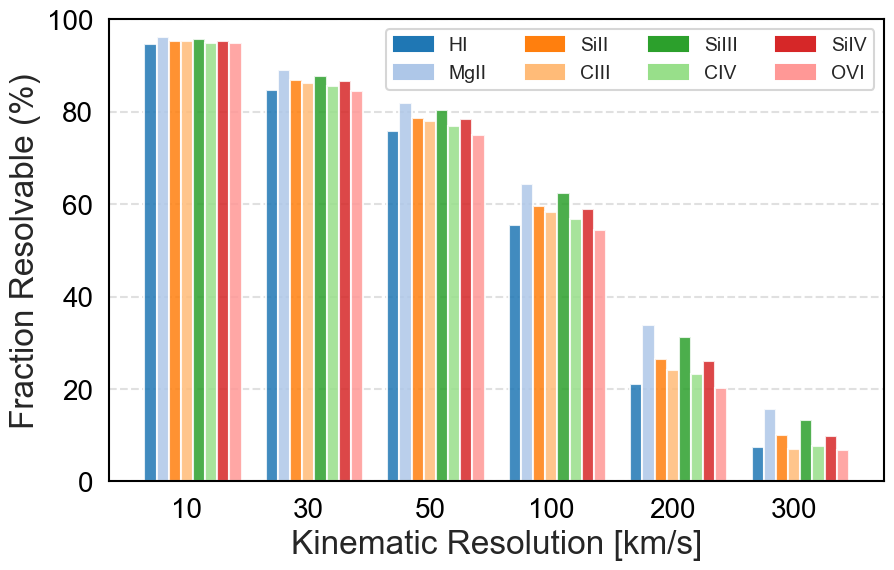

In [139]:
import matplotlib.patches as mpatches
print('orientation',orientation)
fig, ax = plt.subplots(figsize=(10, 6))

# Make figure borders (spines) bold
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color("black")

width = 0.1  # thin bars

# We'll collect one legend handle per ion
legend_handles = {}

for i, res in enumerate(spectral_resolutions):
    base_x = i  # group center for each resolution

    for j, ion in enumerate(ions):
        fraction_list = resolvable_fractions[ion][res]
        frac = 100 * np.nanmean(fraction_list) if len(fraction_list) > 0 else np.nan

        bar_x = base_x - (len(ions) * width) / 2 + j * width
        color = colors[j % len(colors)]
        bar = ax.bar(bar_x, frac, width=width, color=color, alpha=0.85)

        # --- removed per your request ---
        # if not np.isnan(frac):
        #     ax.text(bar_x, frac + 1, ion, ha='center', va='bottom', rotation=90, fontsize=11)

        # Capture a legend handle once per ion
        if ion not in legend_handles:
            legend_handles[ion] = mpatches.Patch(color=color, label=ion)

# Axes formatting
group_centers = [i - 0.5 + (len(ions) * width) / 2 for i in range(len(spectral_resolutions))]
ax.set_xticks(group_centers)
ax.set_xticklabels([f'{res}' for res in spectral_resolutions], fontsize=20)
ax.set_ylabel('Fraction Resolvable (%)', fontsize=24)
ax.set_xlabel('Kinematic Resolution [km/s]', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2)
ax.set_ylim(0, 100)
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
ax.grid(False, axis='x')

# Legend (no per-bar labels)
ax.legend(handles=list(legend_handles.values()), frameon=True, fontsize=14, title_fontsize=14, ncol=4)

output_path = os.path.join(output_dir, 'All_halos', 'resolved_dv_inout_bars')
os.makedirs(output_path, exist_ok=True)
output_file = os.path.join(output_path, f'{region}_{halo_name}_dv_bars_{orientation}_{snap}_{resolution}.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()
plt.close()


Figure 10

In [49]:
#####################################  Figure 10: velocity and emission map for diff spectral and spatiall resolution ###################################


# from collections import defaultdict
# results_dict = defaultdict(dict)

from collections import defaultdict
results_dict = defaultdict(list)
# === Custom emission colormap thresholds ===
cmap_yellow = cmr.take_cmap_colors('cmr.viola_r', 4, cmap_range=(0.2, 0.25), return_fmt='rgba')   # >200
cmap_purple = cmr.take_cmap_colors('autumn', 4, cmap_range=(0.8, 0.9), return_fmt='rgba')         # >10000
cmap_blue   = cmr.take_cmap_colors('cool', 3, cmap_range=(0.1, 0.2), return_fmt='rgba')           # >100
cmap_gray   = cmr.take_cmap_colors('cmr.neutral_r', 9, cmap_range=(0.1, 0.5), return_fmt='rgba')  # background
combined_cmap = np.hstack([cmap_gray, cmap_blue, cmap_yellow, cmap_purple])
custom_cmap_em = mcolors.LinearSegmentedColormap.from_list('custom_cmap', combined_cmap)
# === Custom velocity colormap thresholds ===
cmap_gray   = cmr.take_cmap_colors('cmr.neutral_r', 2, cmap_range=(0.1, 0.5), return_fmt='rgba')  # background
cmap_red    = cmr.take_cmap_colors('seismic', 5, cmap_range=(0.6, 0.7), return_fmt='rgba')   # bright red
cmap_green  = cmr.take_cmap_colors('cmr.watermelon', 3, cmap_range=(0.0, 0.2), return_fmt='rgba')      # bright green
cmap_blue = cmr.take_cmap_colors('winter', 5, cmap_range=(0.1, 0.5), return_fmt='rgba')     # bright orange
combined_cmap_dv = np.hstack([cmap_gray, cmap_green, cmap_red, cmap_blue])
custom_cmap_dv = mcolors.LinearSegmentedColormap.from_list('custom_cmap_dv', combined_cmap_dv)

# === Thresholds ===
dv_thresh_list = [200,100,30]
sb_thresh_list = [100,1000,2000]
dv_thresh = 100
sb_thresh = 100

# === Helper function to load emission + delta_v maps ===
def load_maps(file_path_cgm, file_path_io, ion, orientation, region):
    
    with h5py.File(file_path_cgm, 'r') as f_cgm:
        zgroup = list(f_cgm.keys())[0]
        grp_cgm = f_cgm[zgroup]
        emission = np.array(grp_cgm[f"{ion}_emission_{orientation}_{region}"])

    with h5py.File(file_path_io, 'r') as f_io:
        zgroup = list(f_io.keys())[0]
        grp_io = f_io[zgroup]
        v_in = np.array(grp_io[f"{ion}_vlos_emissweighted_{orientation}_inflow"])
        v_out = np.array(grp_io[f"{ion}_vlos_emissweighted_{orientation}_outflow"])

    delta_v = np.abs(v_in - v_out)
    return emission, delta_v
# === Plotting setup ===
regions = ['cgm']
for dv_thresh in dv_thresh_list:
    for sb_thresh in sb_thresh_list:
        for region in regions:
            for orientation in orientations:
                for halo in halos:
                    halo_name = halo_dict[halo]
                    foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)
                    for ion in ions:
                        #fig, axes = plt.subplots(len(resolutions), 3, figsize=(16, 6 * len(resolutions)))
                        fig = plt.figure(figsize=(17, 6 * len(resolutions)))
                        gs = fig.add_gridspec(len(resolutions), 3, wspace=0.01, hspace=0.001)
                        axes = np.empty((len(resolutions), 3), dtype=object)
                        for i in range(len(resolutions)):
                            for j in range(3):
                                axes[i, j] = fig.add_subplot(gs[i, j])


                        for i, res in enumerate(resolutions):
                            # Construct file paths for current resolution
                            prefix_io = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                                    f'box_{box_name}', 'inflow_outflow', str(res))
                            file_path_io = os.path.join(prefix_io, 'FRBs', f"{halo_name}_emission_maps.hdf5")

                            prefix_cgm = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                                    f'box_{box_name}', 'without_disk', str(res), 'disk_cgm')
                            file_path_cgm = os.path.join(prefix_cgm, 'FRBs', f"{halo_name}_emission_maps.hdf5")
                            print(file_path_cgm)
                            
                            # Load maps
                            emission, delta_v = load_maps(file_path_cgm, file_path_io, ion, orientation, region)

                            # --- Column 1: Δv map ---
                            dv_display = delta_v#np.full_like(delta_v, np.nan)
                            dv_display[delta_v > dv_thresh] = delta_v[delta_v > dv_thresh]
                            ax0 = axes[i, 0]
                            im0 = ax0.imshow(dv_display, origin='lower', cmap=custom_cmap_dv, vmin=0, vmax=300)
                            if i == 0:
                                ax0.set_title(f"Δv (Inflow - Outflow) Map", fontsize=18)
                            ax0.set_xticks([])
                            ax0.set_yticks([])
                            ax0.tick_params(left=False, bottom=False)
                            ax0.set_ylabel(f"{res} kpc", fontsize=20)
                            for spine in ax0.spines.values():
                                spine.set_linewidth(2)


                            # --- Column 2: Emission map ---
                            em_display = emission#np.full_like(emission, np.nan)
                            em_display[emission > sb_thresh] = emission[emission > sb_thresh]
                            vmin_em, vmax_em = 1, 5e4  
                            ax1 = axes[i, 1]
                            im1 = ax1.imshow(em_display, origin='lower', cmap=custom_cmap_em,norm=LogNorm(vmin=vmin_em, vmax=vmax_em))
                            if i == 0:
                                ax1.set_title("Surface Brightness Map", fontsize=16)
                            ax1.set_xticks([])
                            ax1.set_yticks([])
                            ax1.tick_params(left=False, bottom=False)
                            for spine in ax1.spines.values():
                                spine.set_linewidth(2)

                            # --- Column 3: Resolvable pixels (Δv > 100 & SB > 100) ---
                            mask = (emission > sb_thresh) & (delta_v > dv_thresh)
                            display_mask = np.zeros_like(delta_v)
                            display_mask[mask] = delta_v[mask]
                            #
                            total_pixels = np.sum(emission > sb_thresh)#delta_v.size
                            if total_pixels == 0:
                                resolvable_fraction = 0.0  # or np.nan, depending on your preference
                            else:
                                resolvable_pixels = np.sum((emission > sb_thresh) & (delta_v > dv_thresh))
                                resolvable_fraction = (resolvable_pixels / total_pixels) * 100
                            #results_dict[(ion, res, dv_thresh, sb_thresh)] = resolvable_fraction
                            results_dict[(ion, res, dv_thresh, sb_thresh)].append(resolvable_fraction)

                            #           

                            ax2 = axes[i, 2]
                            im2 = ax2.imshow(display_mask, origin='lower', cmap=custom_cmap_dv, vmin=0, vmax=300)
                            if i == 0:
                                ax2.set_title(f"Resolvable Pixels (Δv > {dv_thresh} & SB > {sb_thresh})", fontsize=16)
                            ax2.set_xticks([])
                            ax2.set_yticks([])
                            ax2.tick_params(left=False, bottom=False)
                            for spine in ax2.spines.values():
                                spine.set_linewidth(2)

                        #fig.suptitle(f"{halo_name} - {orientation} - {ion}", fontsize=20, y=0.92)
                        # Shared colorbars
                        cbar_ax2 = fig.add_axes([0.91, 0.15, 0.02, 0.35])
                        cb2 = fig.colorbar(im1, cax=cbar_ax2)
                        cb2.set_label('Surface Brightness [photons s⁻¹ cm⁻² sr⁻¹]', fontsize=14, labelpad=14)
                        cb2.ax.tick_params(labelsize=16, length=6, width=2)

                        cbar_ax1 = fig.add_axes([0.91, 0.52, 0.02, 0.35])
                        cb1 = fig.colorbar(im0, cax=cbar_ax1)
                        cb1.set_label('$\Delta$v (Inflow - Outflow) [km/s]', fontsize=16, labelpad=14)
                        cb1.ax.tick_params(labelsize=14, length=6, width=2)  # Increase tick font and size

    

                        plt.tight_layout()
                        out_dir = os.path.join(output_dir, 'All_halos', 'resolved_dv_em_maps', f'z={z}',f'{orientation}')
                        os.makedirs(out_dir, exist_ok=True)
                        out_file = os.path.join(out_dir, f'{halo_name}_{orientation}_{ion}_dv{dv_thresh}_em{sb_thresh}.png')
                        #plt.savefig(out_file, dpi=300, bbox_inches='tight')
                        #plt.show()

                        plt.close()



<>:143: SyntaxWarning: invalid escape sequence '\D'
<>:143: SyntaxWarning: invalid escape sequence '\D'
/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_81534/4091627805.py:143: SyntaxWarning: invalid escape sequence '\D'
  cb1.set_label('$\Delta$v (Inflow - Outflow) [km/s]', fontsize=16, labelpad=14)
/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_81534/4091627805.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/Users/vidasaeedzadeh/Projects/foggie_outputs/plots_halo_002878/nref11c_nref9f/FOGGIE/RD0032/box_100/without_disk/0.27/disk_cgm/FRBs/Cyclone_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/plots_halo_002878/nref11c_nref9f/FOGGIE/RD0032/box_100/without_disk/1/disk_cgm/FRBs/Cyclone_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/plots_halo_002878/nref11c_nref9f/FOGGIE/RD0032/box_100/without_disk/3/disk_cgm/FRBs/Cyclone_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/plots_halo_002878/nref11c_nref9f/FOGGIE/RD0032/box_100/without_disk/6/disk_cgm/FRBs/Cyclone_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/plots_halo_002878/nref11c_nref9f/FOGGIE/RD0032/box_100/without_disk/0.27/disk_cgm/FRBs/Cyclone_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/plots_halo_002878/nref11c_nref9f/FOGGIE/RD0032/box_100/without_disk/1/disk_cgm/FRBs/Cyclone_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/plots_

Figure 11

Saved figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/summary_plots/all_halos_avg_3ions_summary_by_resolution.png


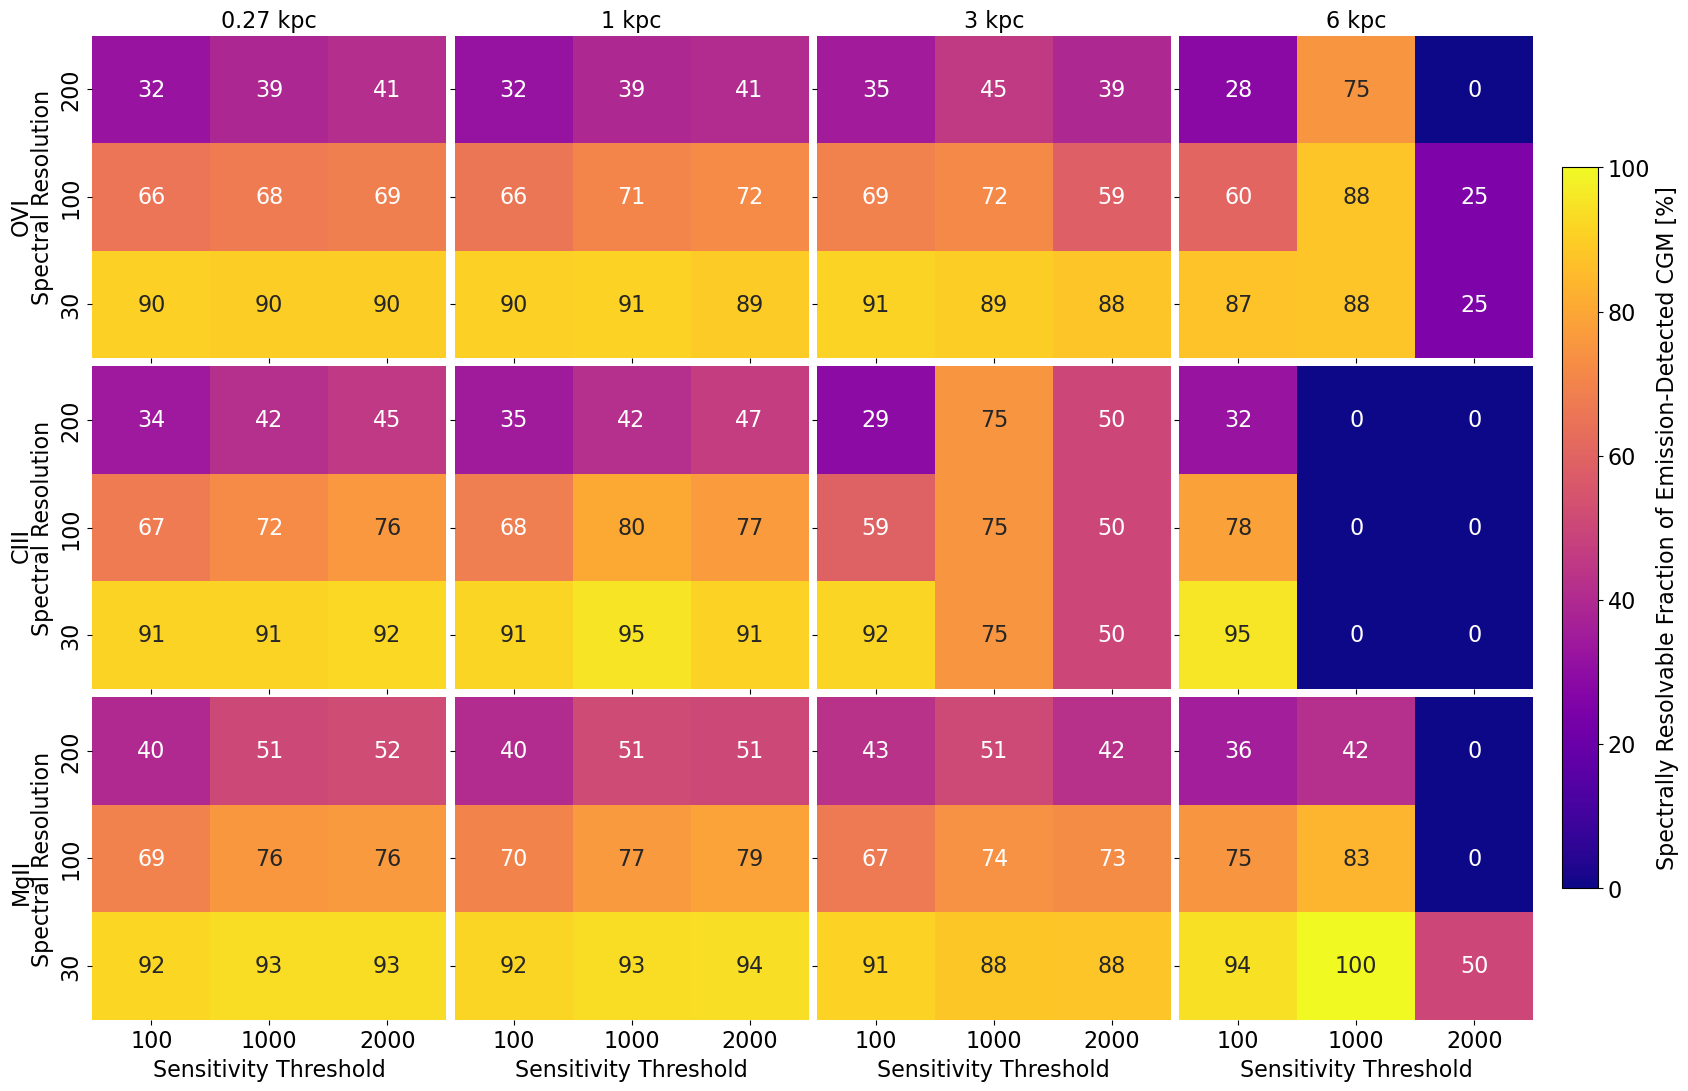

In [51]:
#####################################  Figure 11: average resolvable fraction across halos ###################################
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ions = ['OVI', 'CIII', 'MgII']

n_rows = len(ions)
n_cols = len(resolutions)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4.2 * n_cols, 3.6 * n_rows),
    constrained_layout=True,
    sharex=True, sharey=True
)
axes = np.atleast_2d(axes)

last_hm = None
for i, ion_to_plot in enumerate(ions):
    for j, res_to_plot in enumerate(resolutions):
        ax = axes[i, j]
        data = np.zeros((len(dv_thresh_list), len(sb_thresh_list)))

        for r, dv in enumerate(dv_thresh_list):
            for c, sb in enumerate(sb_thresh_list):
                key = (ion_to_plot, res_to_plot, dv, sb)
                vals = results_dict.get(key, [])

                # Backward-compat: if earlier code stored a single number, wrap it
                if not isinstance(vals, (list, tuple, np.ndarray)):
                    vals = [vals]

                data[r, c] = np.nan if len(vals) == 0 else np.nanmean(vals)

        hm = sns.heatmap(
            data, annot=True, fmt=".0f",
            xticklabels=sb_thresh_list, yticklabels=dv_thresh_list,
            cmap="plasma", vmin=0, vmax=100,
            cbar=False, ax=ax, annot_kws={"size": 16}
        )
        ax.tick_params(axis='both', labelsize=16)
        last_hm = hm

        if i == 0:
            ax.set_title(f"{res_to_plot} kpc", fontsize=16)
        if i == n_rows - 1:
            ax.set_xlabel("Sensitivity Threshold", fontsize=16)
        if j == 0:
            ax.set_ylabel("Spectral Resolution", fontsize=16)
            ax.text(-0.2, 0.5, ion_to_plot, va='center', ha='right',
                    rotation=90, rotation_mode='anchor',
                    transform=ax.transAxes, fontsize=16)

# Shared colorbar
cbar = fig.colorbar(last_hm.collections[0], ax=axes, orientation="vertical", fraction=0.025, pad=0.02)
cbar.set_label("Spectrally Resolvable Fraction of Emission-Detected CGM [%]", fontsize=16)
cbar.ax.tick_params(labelsize=16)

summary_out_dir = os.path.join(output_dir, 'All_halos', 'summary_plots')
os.makedirs(summary_out_dir, exist_ok=True)
out_path = os.path.join(summary_out_dir, "all_halos_avg_3ions_summary_by_resolution.png")
plt.savefig(out_path, dpi=300)
print(f"Saved figure to {out_path}")
plt.show()
plt.close()
#

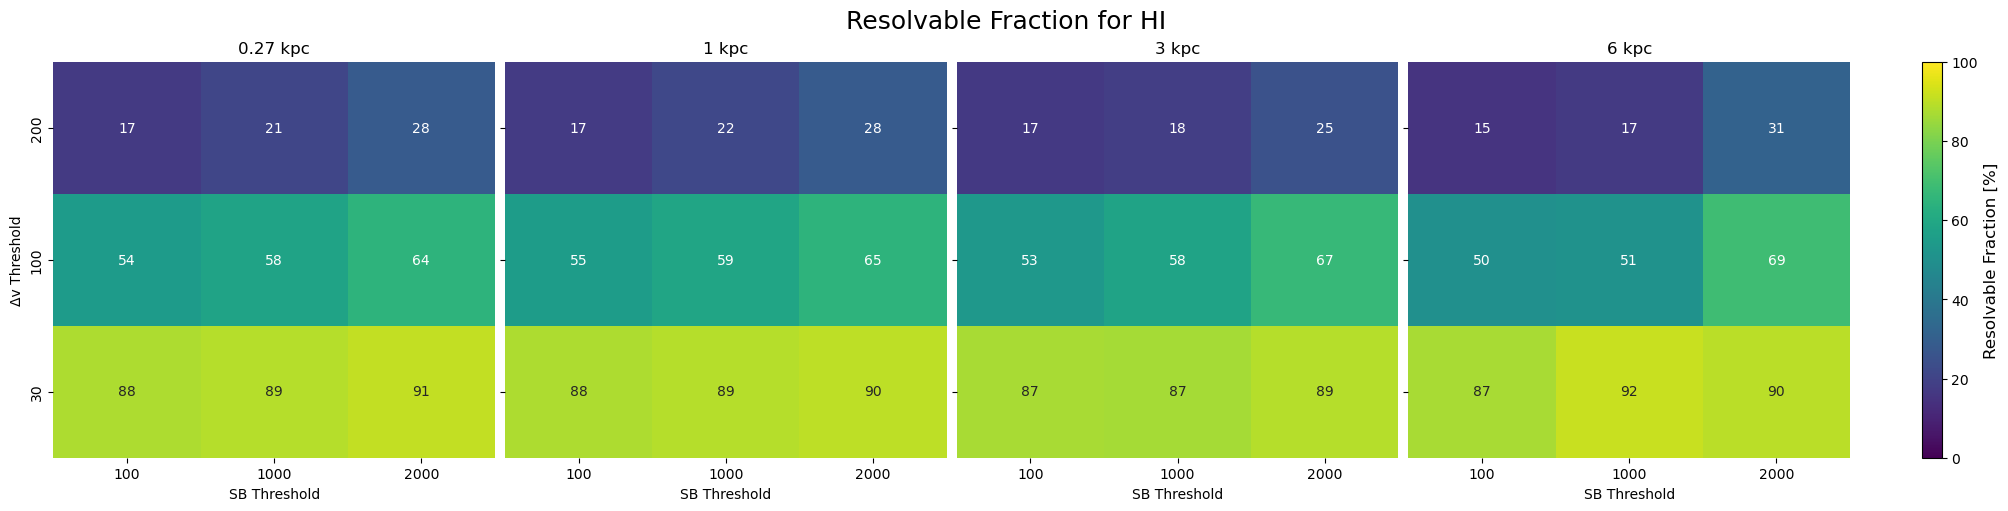

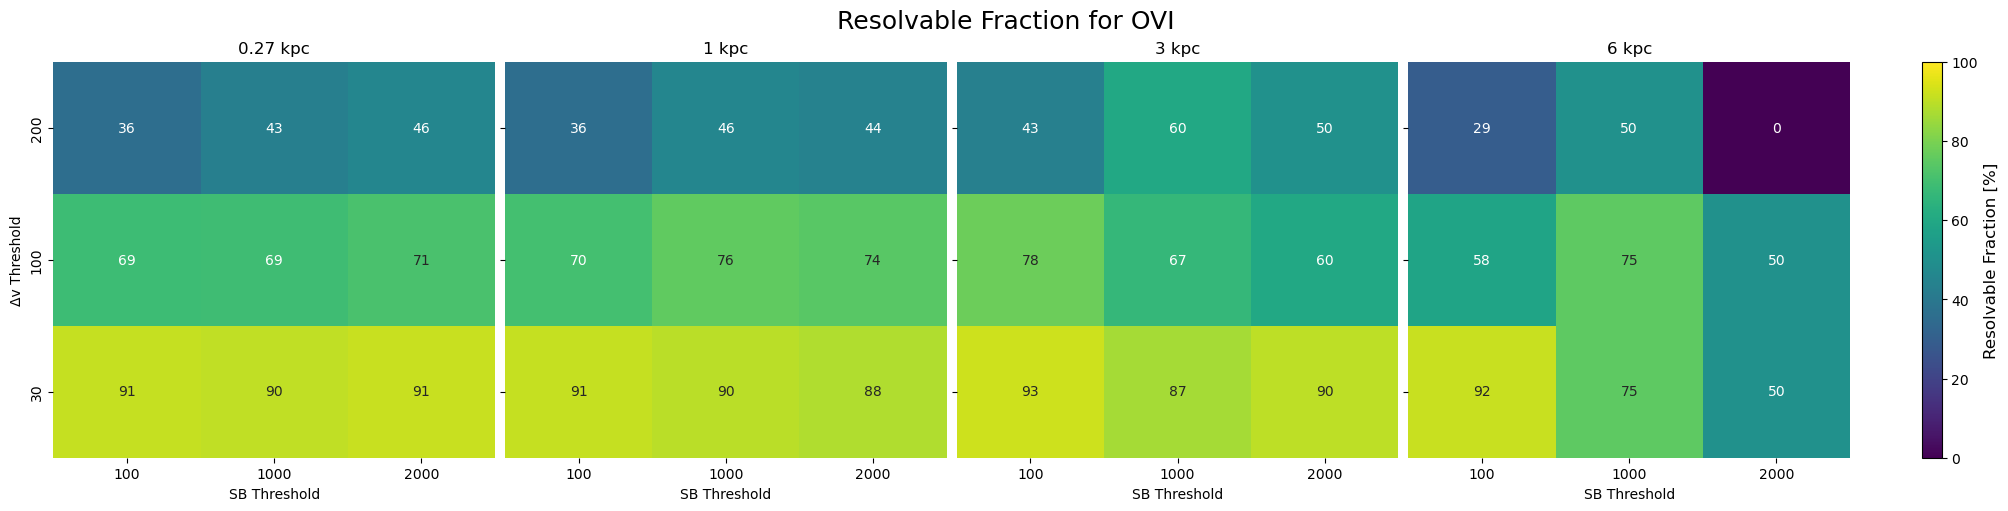

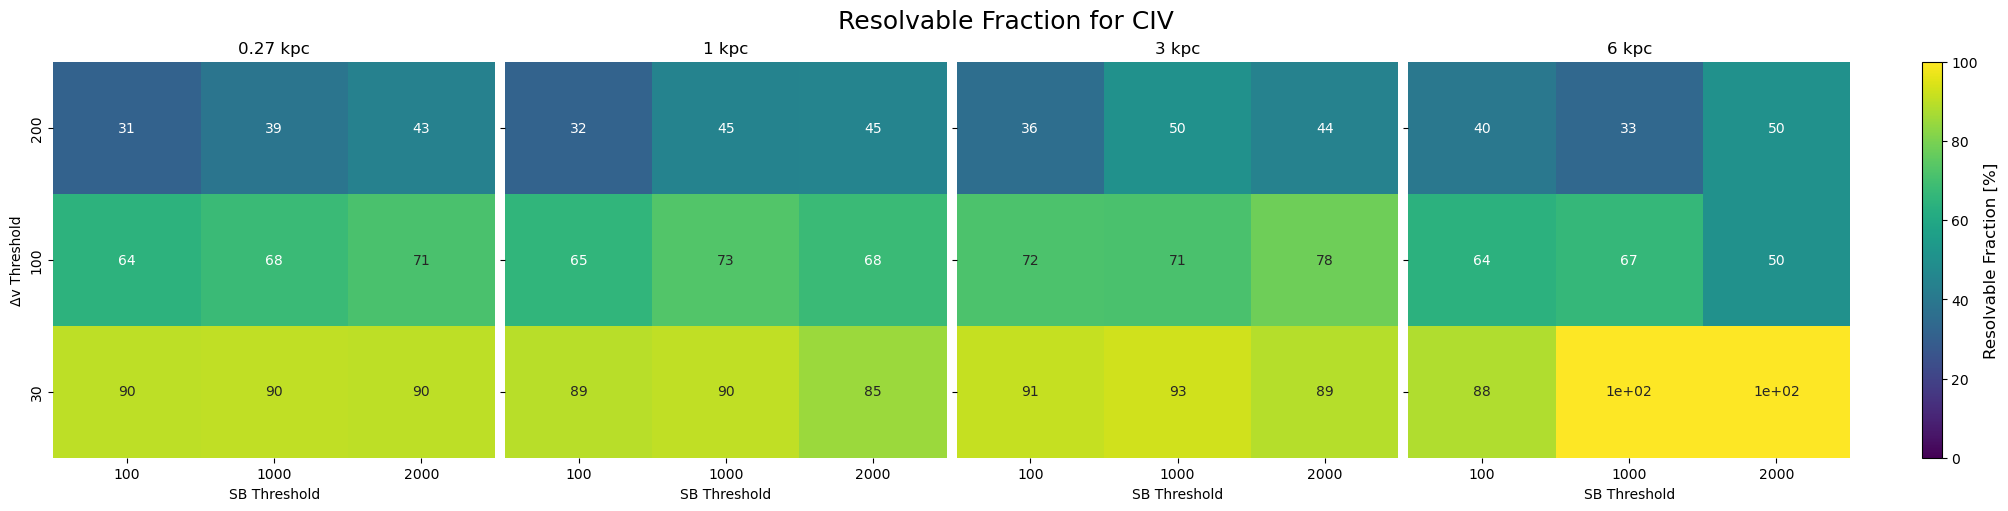

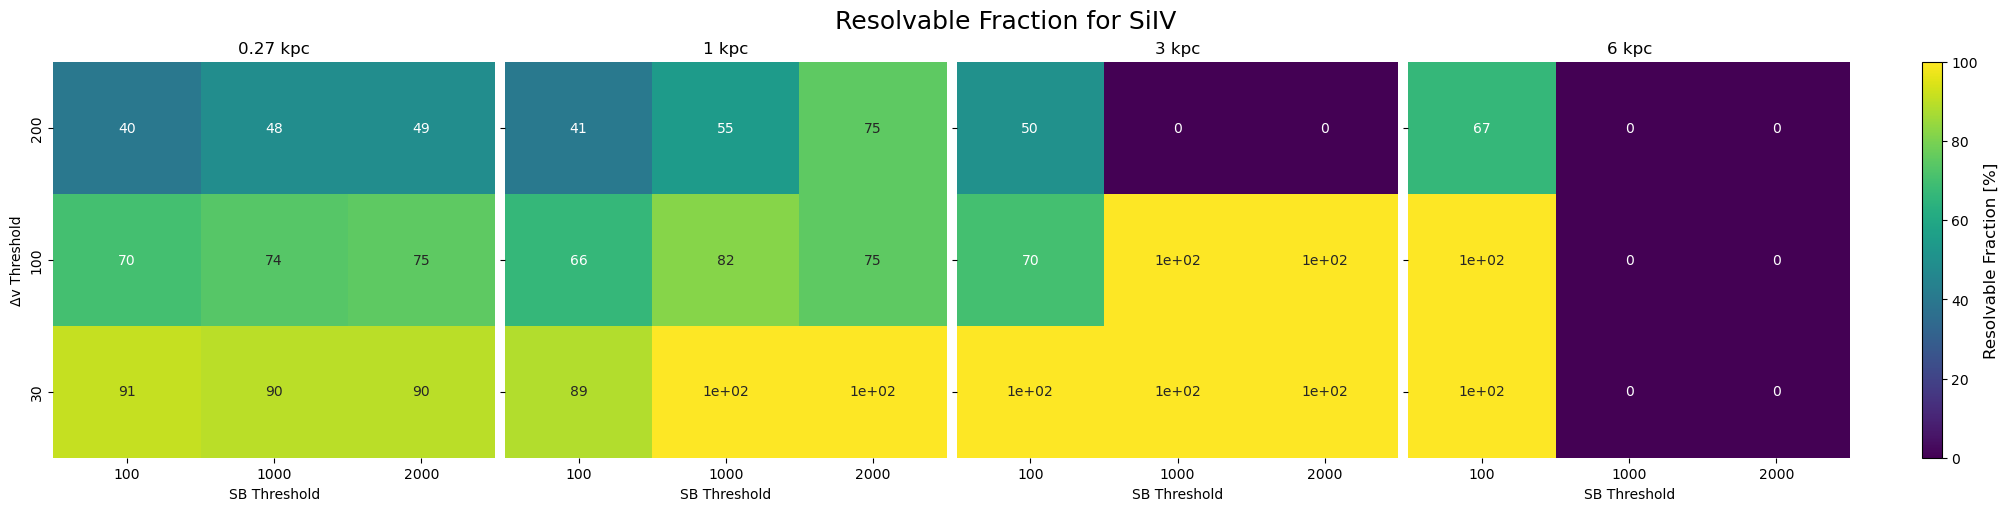

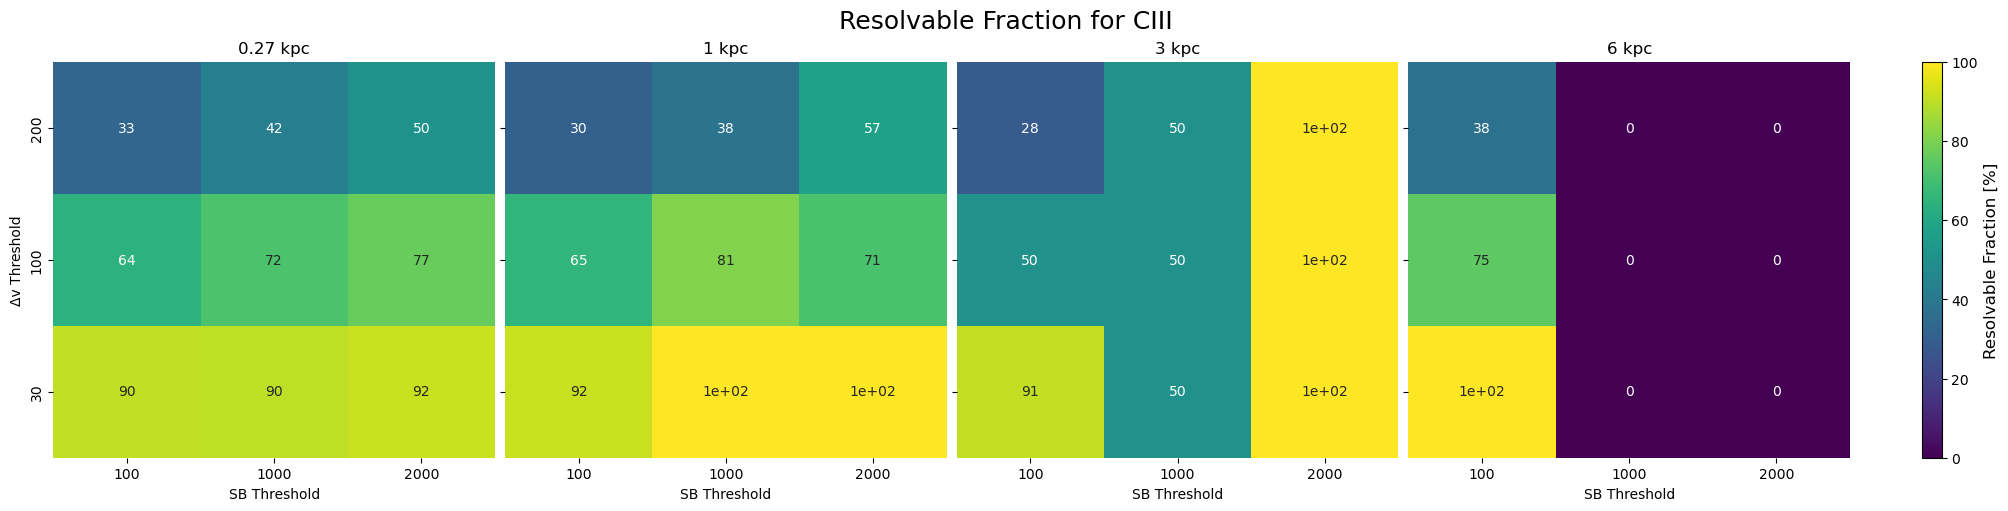

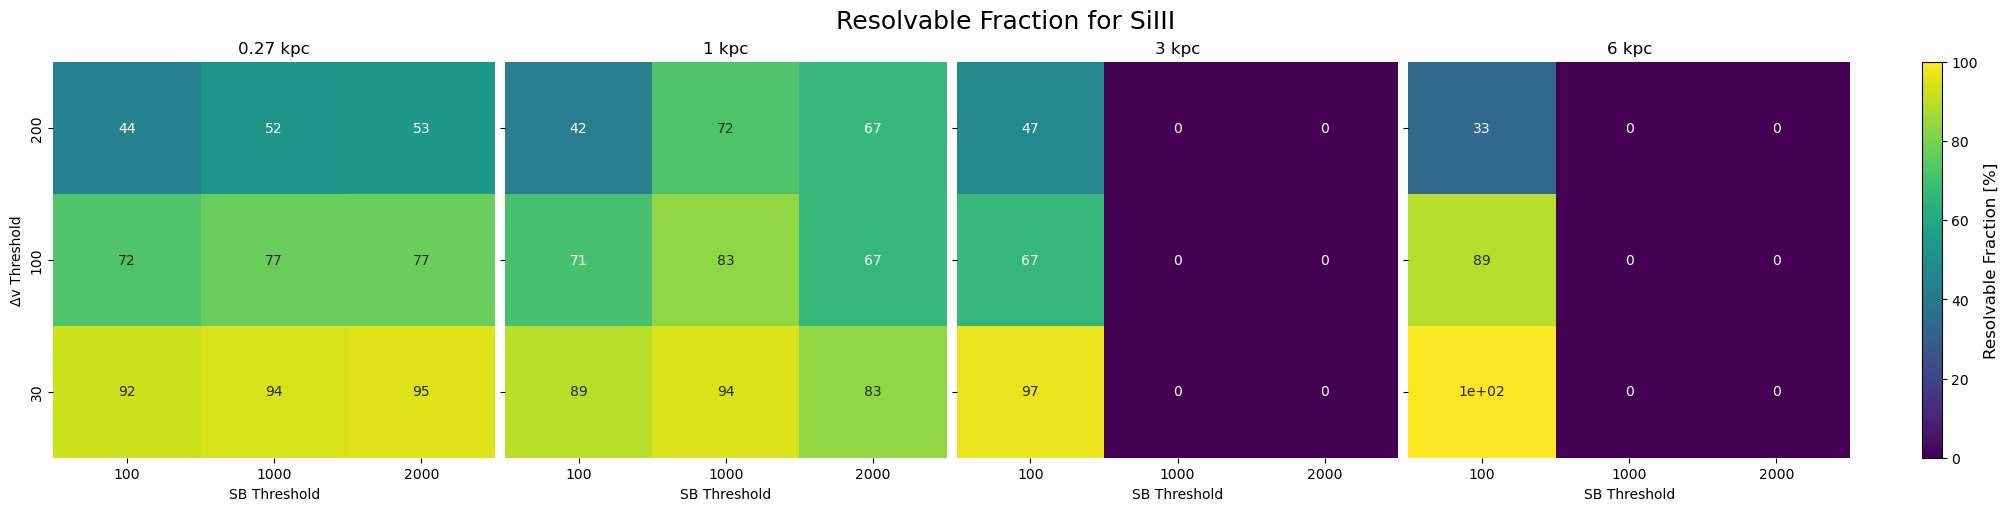

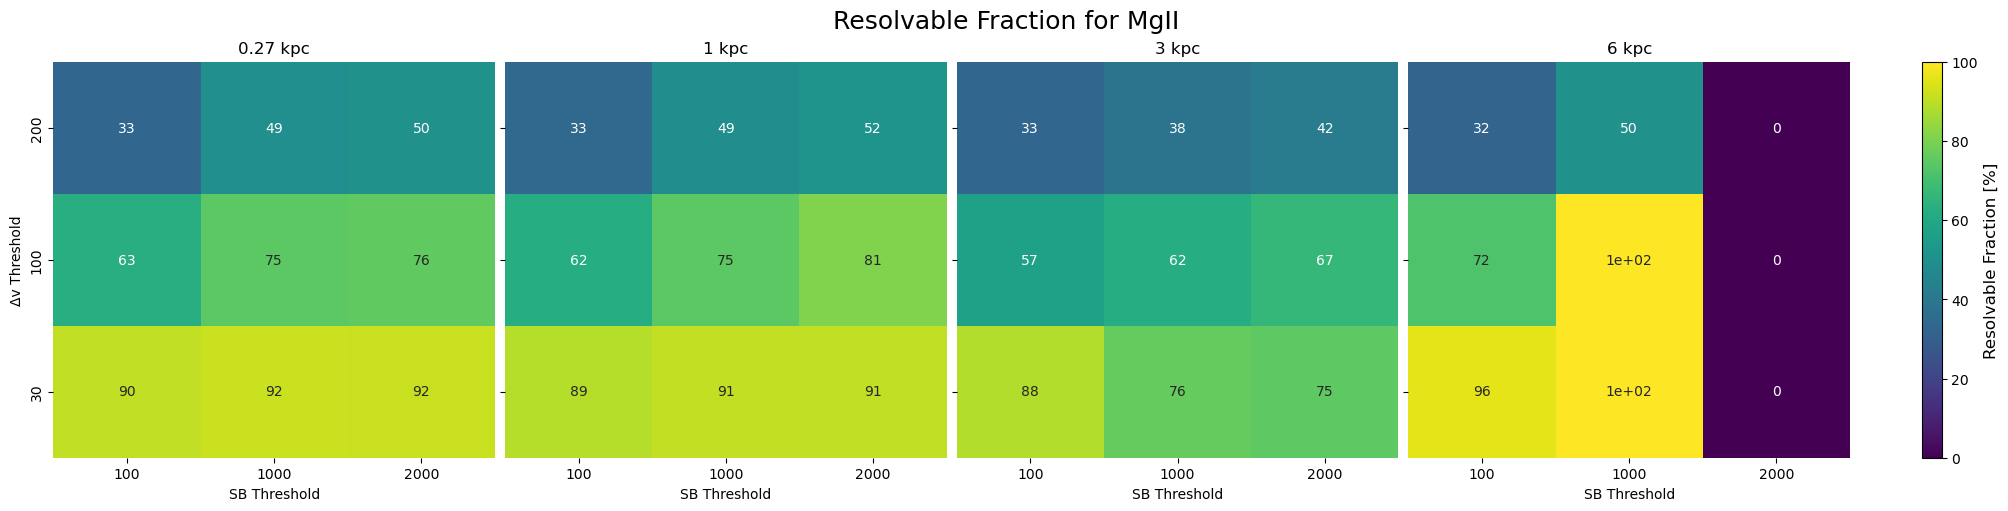

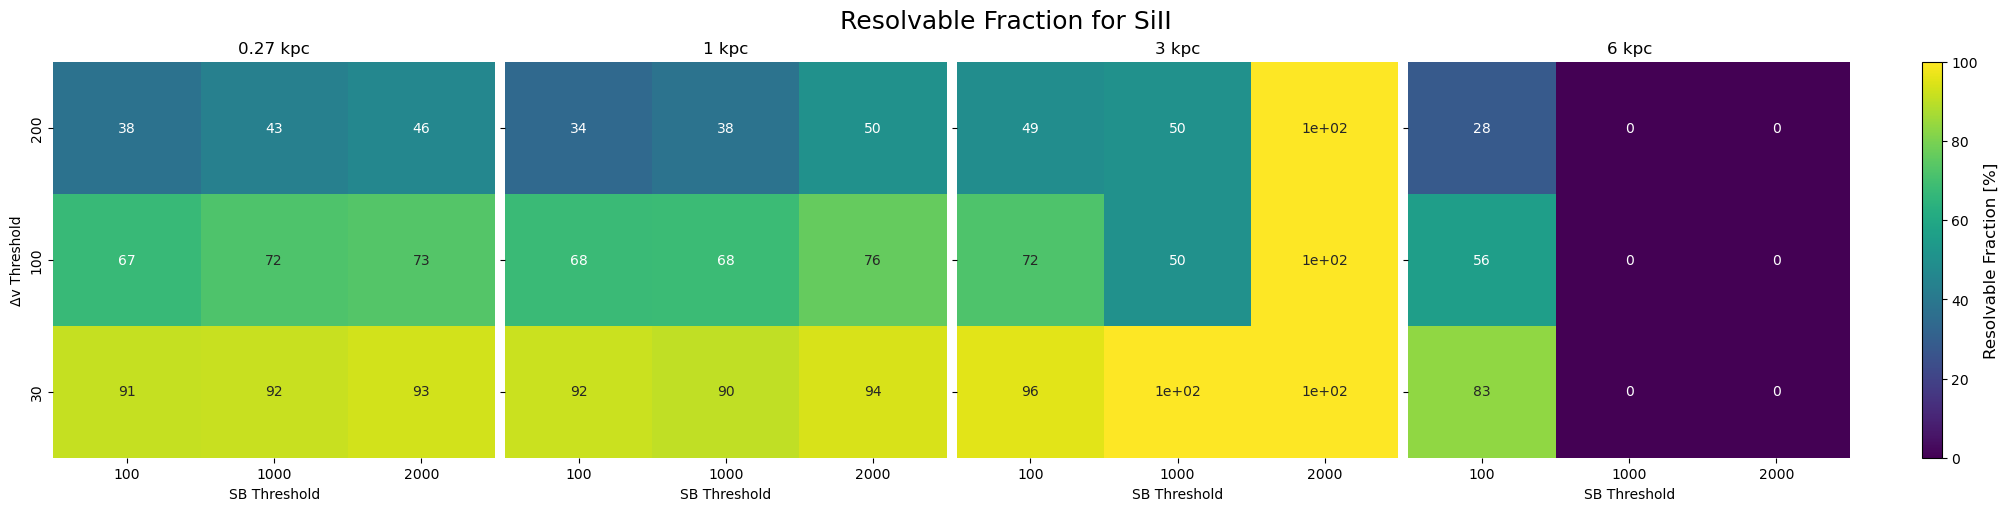

In [30]:
#####################################  Figure 11: what fraction of emission map you can resolve with your spectral resolution ###################################

import matplotlib.pyplot as plt
import seaborn as sns

# Loop over all ions
for ion_to_plot in ions:
    fig, axes = plt.subplots(1, len(resolutions), figsize=(5 * len(resolutions), 5), constrained_layout=True, sharex=True, sharey=True)

    for ax, res_to_plot in zip(axes, resolutions):
        data = np.zeros((len(dv_thresh_list), len(sb_thresh_list)))

        for i, dv in enumerate(dv_thresh_list):
            for j, sb in enumerate(sb_thresh_list):
                key = (ion_to_plot, res_to_plot, dv, sb)
                if key in results_dict:
                    data[i, j] = results_dict[key]
                else:
                    data[i, j] = np.nan  # fallback if a value is missing

        heatmap_img = sns.heatmap(data, annot=True, xticklabels=sb_thresh_list, yticklabels=dv_thresh_list,
                    cmap='viridis', ax=ax, vmin=0, vmax=100,cbar_kws={"label": "Resolvable Fraction [%]"},cbar=False)
        ax.set_title(f"{res_to_plot} kpc")
        if ax == axes[0]:
            ax.set_ylabel('Δv Threshold')
        ax.set_xlabel('SB Threshold')
        

    # Add one shared colorbar
    cbar = fig.colorbar(heatmap_img.collections[0], ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
    cbar.set_label("Resolvable Fraction [%]", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    fig.suptitle(f'Resolvable Fraction for {ion_to_plot}', fontsize=18)
    
    # Save the figure
    summary_out_dir = os.path.join(output_dir, 'All_halos', 'summary_plots')
    os.makedirs(summary_out_dir, exist_ok=True)
    summary_file = os.path.join(summary_out_dir, f"{ion_to_plot}_summary_by_resolution.png")
    plt.savefig(summary_file, dpi=300)
    plt.show()
    plt.close()




Saved figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/summary_plots/Maelstrom_3_ions_summary_by_resolution.png


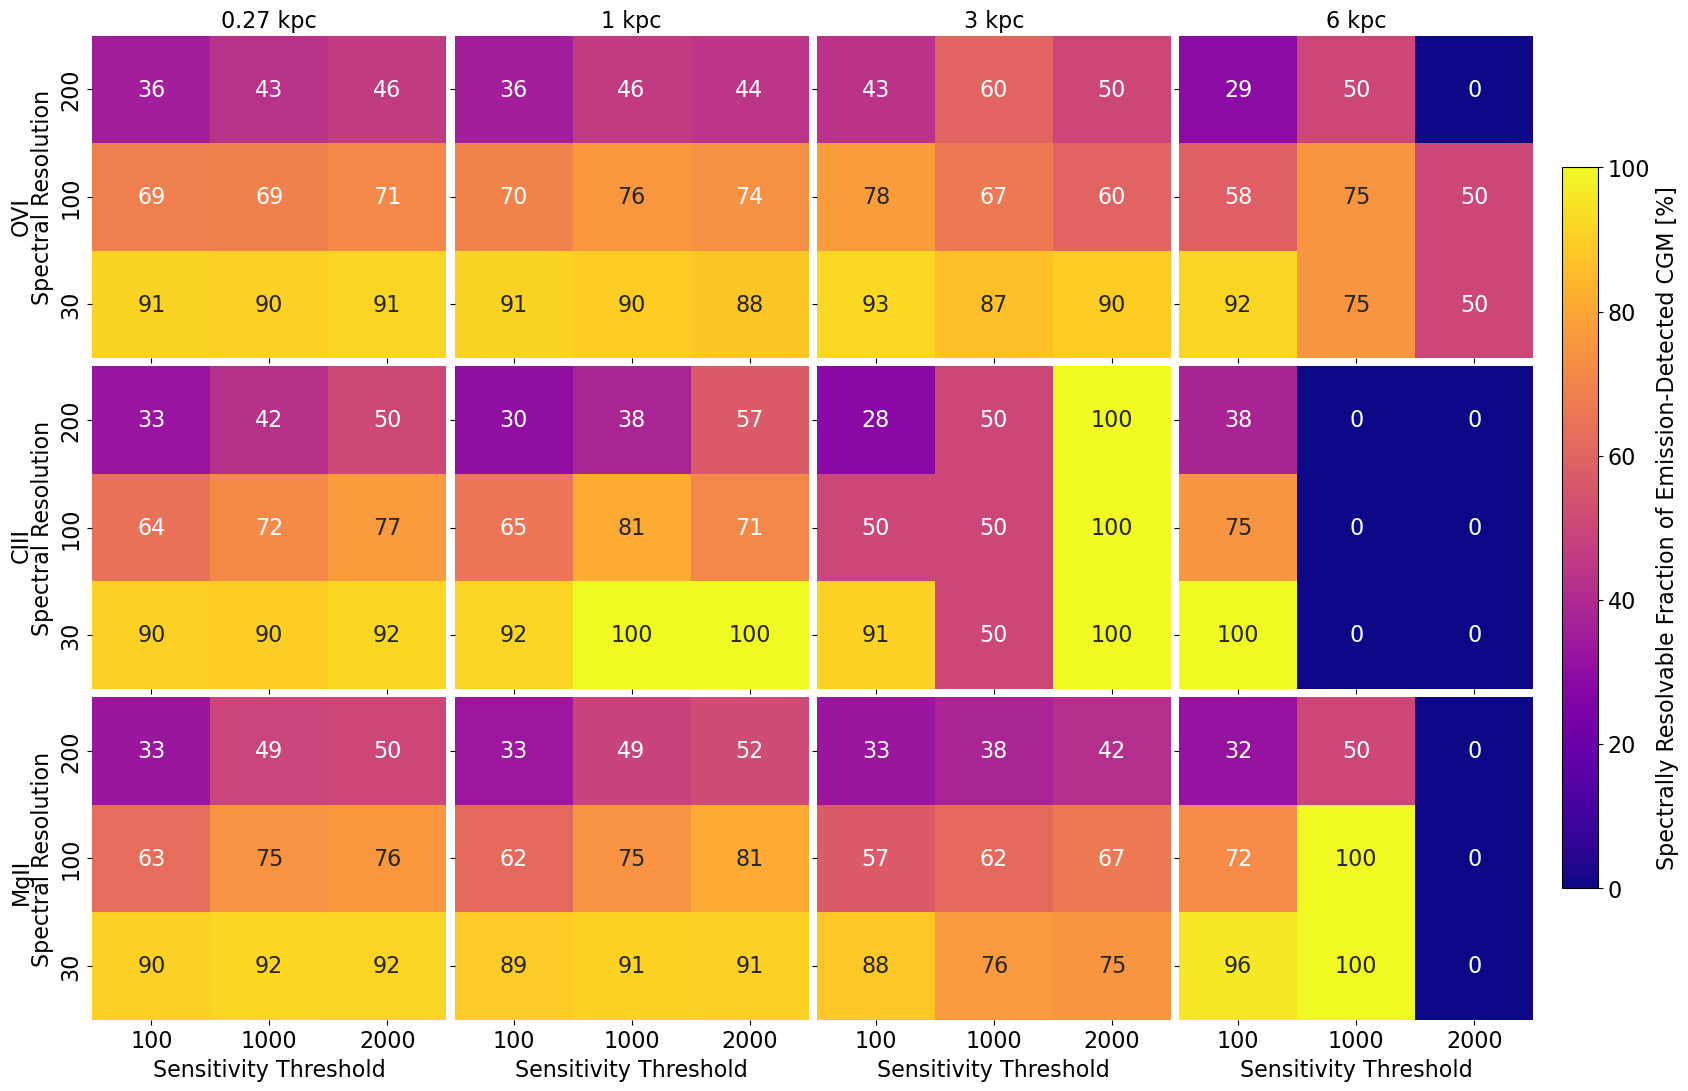

In [46]:
#####################################  Figure 11: what fraction of emission map you can resolve with your spectral resolution ###################################
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ions = ['OVI', 'CIII', 'MgII']

# ions          -> e.g., ['OVI','CIII','MgII']  (order = rows, top→bottom)
# resolutions   -> e.g., [0.27, 1, 3, 6]        (order = cols, left→right)
# dv_thresh_list-> e.g., [200, 100, 30]         (order = heatmap rows, top→bottom)
# sb_thresh_list-> e.g., [100, 1000, 2000]      (order = heatmap cols, left→right)
# results_dict  -> keys: (ion, res_kpc, dv, sb) -> value in [0,100]

n_rows = len(ions)
n_cols = len(resolutions)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4.2 * n_cols, 3.6 * n_rows),
    constrained_layout=True,
    sharex=True, sharey=True
)

# Ensure axes is 2D even if n_rows or n_cols == 1
axes = np.atleast_2d(axes)

last_hm = None
for i, ion_to_plot in enumerate(ions):
    for j, res_to_plot in enumerate(resolutions):
        ax = axes[i, j]
        data = np.zeros((len(dv_thresh_list), len(sb_thresh_list)))
        for r, dv in enumerate(dv_thresh_list):
            for c, sb in enumerate(sb_thresh_list):
                data[r, c] = results_dict.get((ion_to_plot, res_to_plot, dv, sb), np.nan)

        hm = sns.heatmap(
            data, annot=True, fmt=".0f",
            xticklabels=sb_thresh_list, yticklabels=dv_thresh_list,
            cmap="plasma", vmin=0, vmax=100,
            cbar=False, ax=ax,annot_kws={"size": 16}
        )
        ax.tick_params(axis='both', labelsize=16)  # both x and y
        last_hm = hm  # keep reference for colorbar

        # Column titles across the top
        if i == 0:
            ax.set_title(f"{res_to_plot} kpc", fontsize=16)

        # X labels only on bottom row
        if i == n_rows - 1:
            ax.set_xlabel("Sensitivity Threshold", fontsize=16)

        # Y labels only on first column
        if j == 0:
            ax.set_ylabel("Spectral Resolution", fontsize=16)
            # Also add the ion label on the left margin for the row
            ax.text(-0.2, 0.5, ion_to_plot, va='center', ha='right',
                    rotation=90, rotation_mode='anchor', transform=ax.transAxes, fontsize=16)
        else:
            ax.set_ylabel("")

        
            


# Shared colorbar
cbar = fig.colorbar(last_hm.collections[0], ax=axes, orientation="vertical", fraction=0.025, pad=0.02)
cbar.set_label("Spectrally Resolvable Fraction of Emission-Detected CGM [%]",fontsize=16)
cbar.ax.tick_params(labelsize=16)
#fig.suptitle("Spectrally Resolvable Fraction vs. Sensitivity & Spectral Resolution", fontsize=18)

# Save
summary_out_dir = os.path.join(output_dir, 'All_halos', 'summary_plots')
os.makedirs(summary_out_dir, exist_ok=True)
out_path = os.path.join(summary_out_dir, "Maelstrom_3_ions_summary_by_resolution.png")
plt.savefig(out_path, dpi=300)
print(f"Saved figure to {out_path}")
plt.show()
plt.close()


In [48]:
from collections import defaultdict
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Assumptions:
# - You have a list of halos: halo_names
# - Per-halo results are stored in a dict keyed like:
#   results_dict_per_halo[(halo, ion, res_kpc, dv, sb)] = value in [0,100]
# If your structure differs, adapt the loop that builds `avg_results`.

# ----- 1) Average across halos -----
agg = defaultdict(list)

for halo in halos:
    for ion in ions:
        for res in resolutions:
            for dv in dv_thresh_list:
                for sb in sb_thresh_list:
                    key_h = (halo, ion, res, dv, sb)
                    if key_h in results_dict_per_halo:
                        agg[(ion, res, dv, sb)].append(results_dict_per_halo[key_h])

avg_results = {}
for k, vals in agg.items():
    avg_results[k] = float(np.nanmean(vals)) if len(vals) else np.nan

# (Optional) If you also want the std:
# std_results = {k: float(np.nanstd(v)) for k, v in agg.items()}

# ----- 2) Plot the 3×4 grid with the averages -----
n_rows, n_cols = len(ions), len(resolutions)
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4.2 * n_cols, 3.6 * n_rows),
    constrained_layout=True,
    sharex=True, sharey=True
)
axes = np.atleast_2d(axes)
last_hm = None

for i, ion in enumerate(ions):
    for j, res in enumerate(resolutions):
        ax = axes[i, j]
        data = np.zeros((len(dv_thresh_list), len(sb_thresh_list))) * np.nan
        for r, dv in enumerate(dv_thresh_list):
            for c, sb in enumerate(sb_thresh_list):
                data[r, c] = avg_results.get((ion, res, dv, sb), np.nan)

        hm = sns.heatmap(
            data, annot=True, fmt=".0f",
            xticklabels=sb_thresh_list, yticklabels=dv_thresh_list,
            cmap="viridis", vmin=0, vmax=100,
            cbar=False, ax=ax,
            annot_kws={"size": 12}         # bigger annotation numbers
        )
        last_hm = hm

        if i == 0:
            ax.set_title(f"{res} kpc", fontsize=12)
        if i == n_rows - 1:
            ax.set_xlabel("Sensitivity Threshold", fontsize=12)
        ax.tick_params(axis='both', labelsize=12)

        if j == 0:
            ax.set_ylabel("Spectral Resolution", fontsize=12)
            ax.text(-0.45, 0.5, ion, va='center', ha='right',
                    rotation=90, rotation_mode='anchor',
                    transform=ax.transAxes, fontsize=12)

# Shared colorbar
cbar = fig.colorbar(last_hm.collections[0], ax=axes, orientation="vertical", fraction=0.025, pad=0.02)
cbar.set_label("Spectrally Resolvable Fraction of Emission-Detected CGM [%]", fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.suptitle(f"Average over {len(halo_names)} halos", fontsize=14)

# Save
summary_out_dir = os.path.join(output_dir, 'All_halos', 'summary_plots')
os.makedirs(summary_out_dir, exist_ok=True)
out_path = os.path.join(summary_out_dir, "all_ions_summary_by_resolution__AVERAGE.png")
#plt.savefig(out_path, dpi=300)
plt.show()
plt.close()


NameError: name 'results_dict_per_halo' is not defined

all
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/0.27/FRBs/Maelstrom_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/1/FRBs/Maelstrom_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/3/FRBs/Maelstrom_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/6/FRBs/Maelstrom_emission_maps.hdf5


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_53724/3268520812.py:208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/resolved_dv_em_maps/z=0.5/edge/cmapv02_Maelstrom_edge_OVI_dv200_em100.png


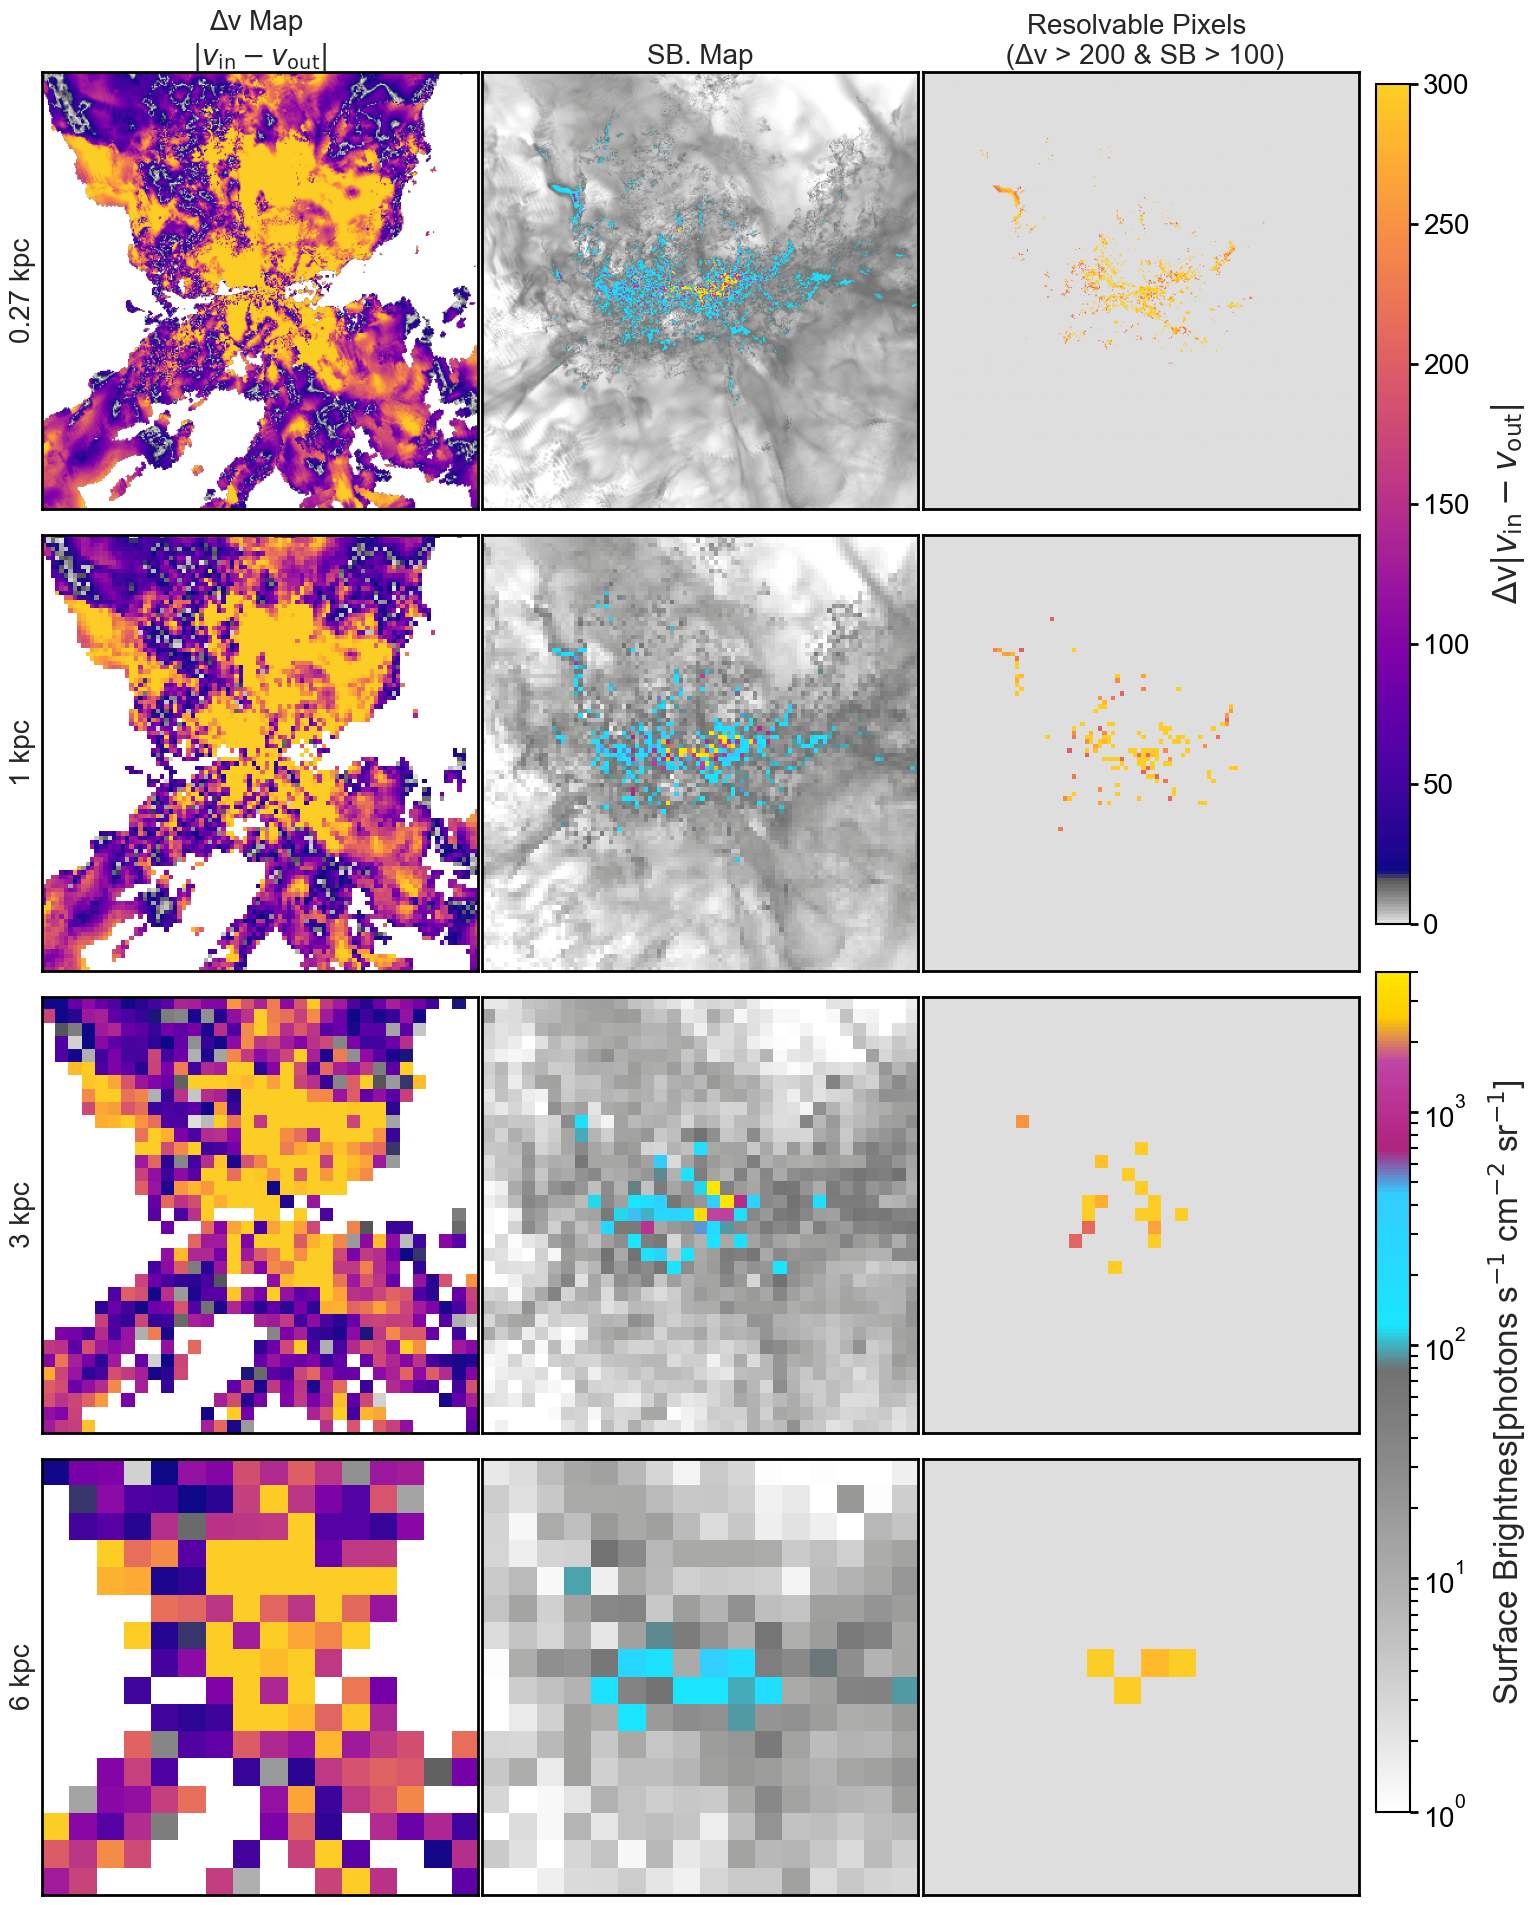

all
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/0.27/FRBs/Maelstrom_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/1/FRBs/Maelstrom_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/3/FRBs/Maelstrom_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/6/FRBs/Maelstrom_emission_maps.hdf5
Saved figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/resolved_dv_em_maps/z=0.5/edge/cmapv02_Maelstrom_edge_OVI_dv100_em100.png


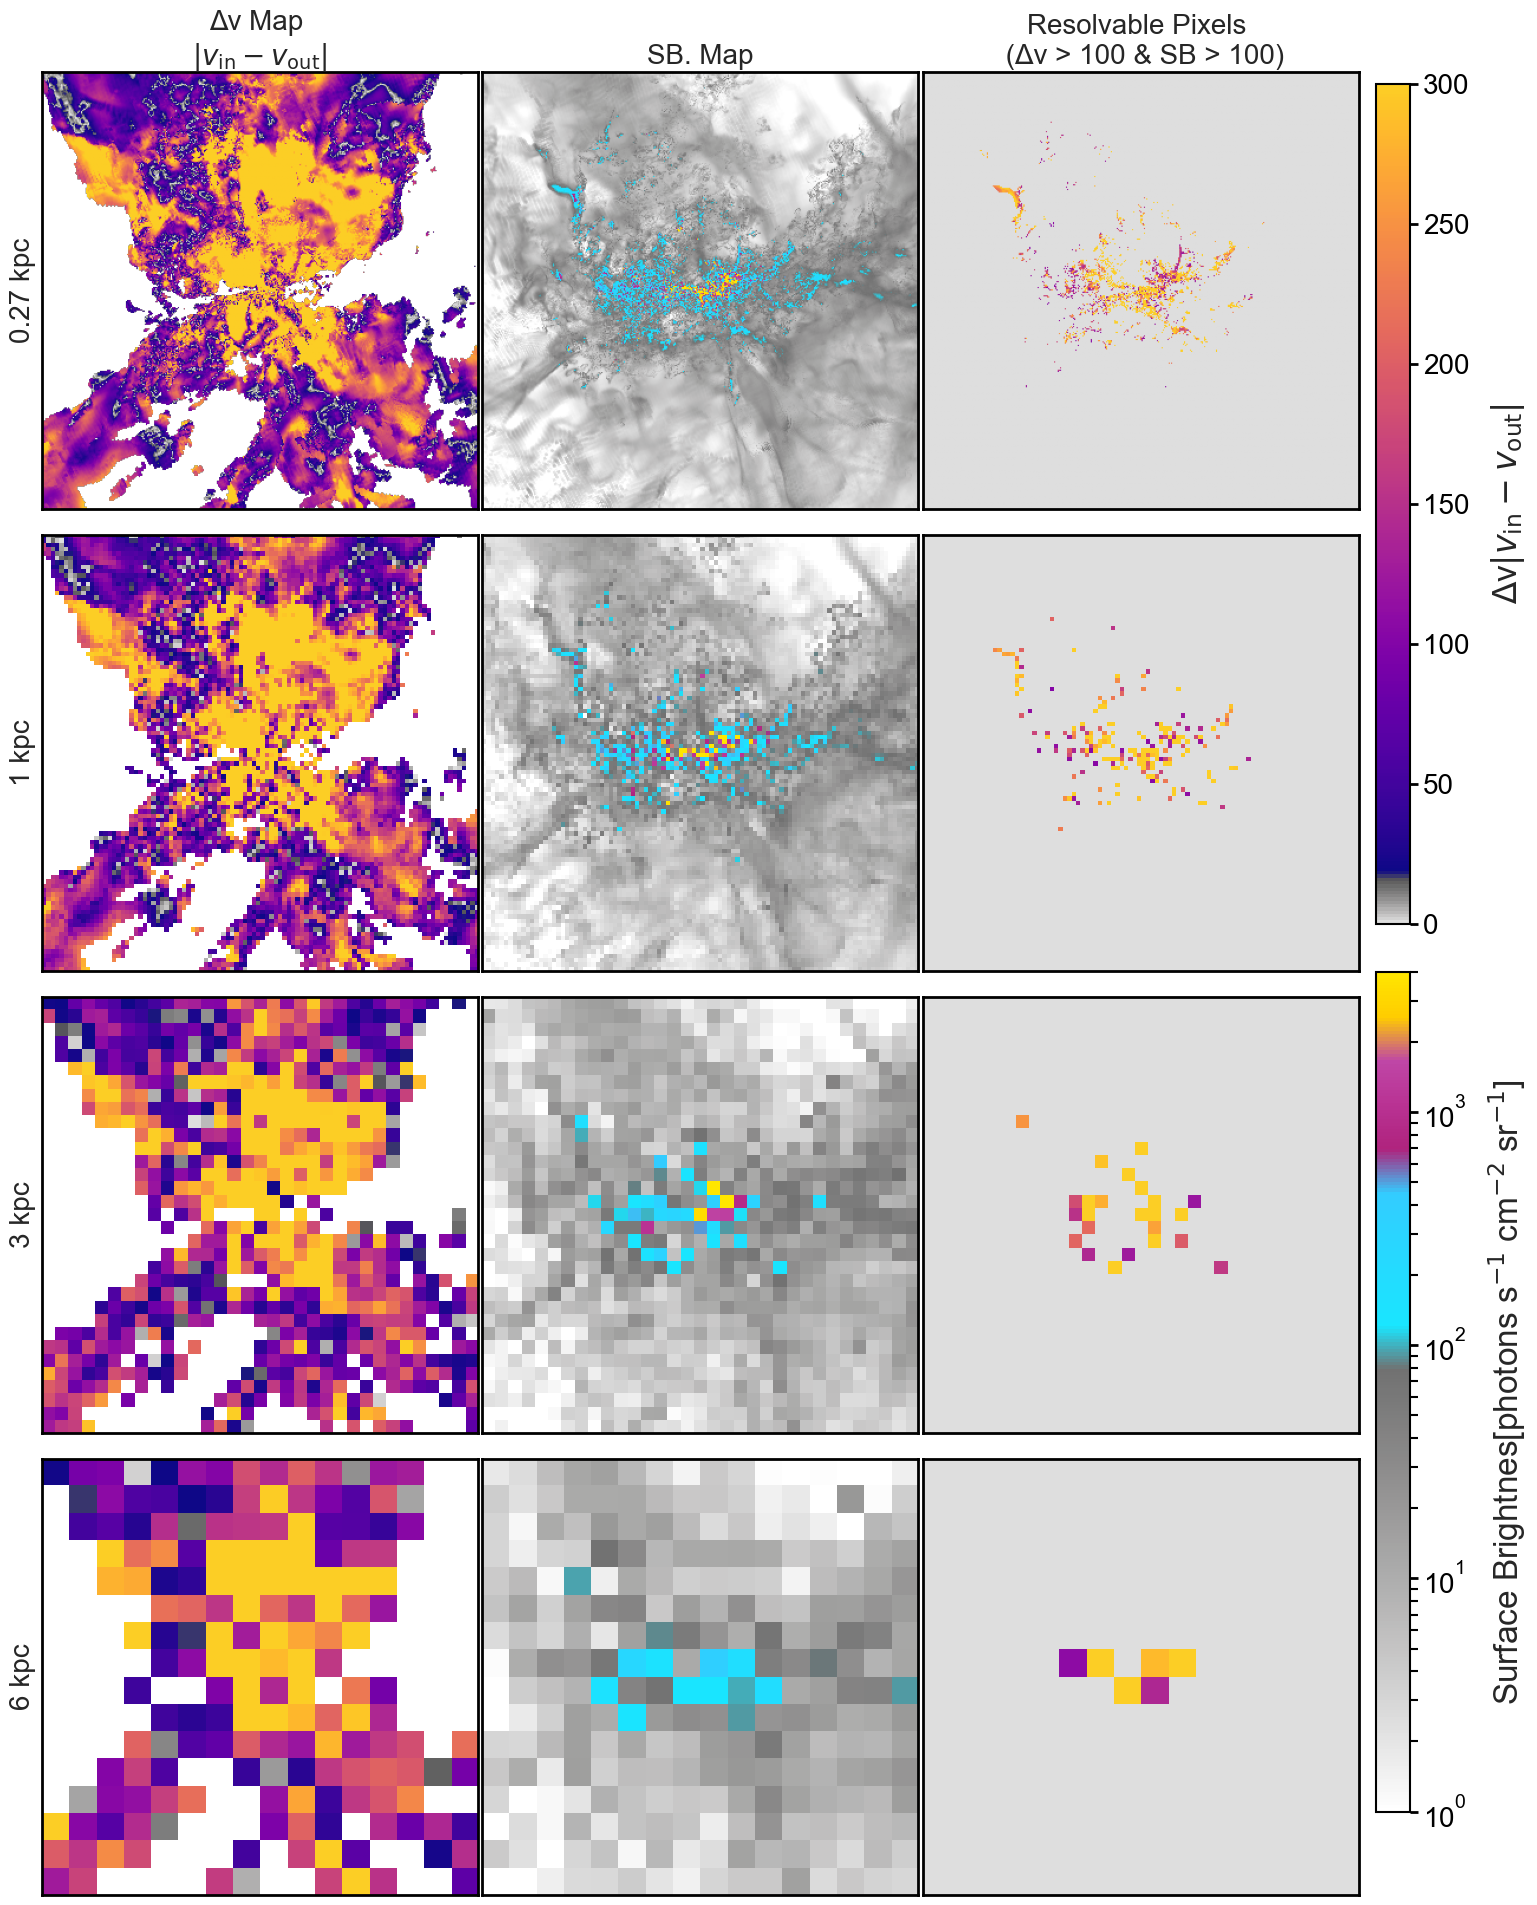

all
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/0.27/FRBs/Maelstrom_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/1/FRBs/Maelstrom_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/3/FRBs/Maelstrom_emission_maps.hdf5
/Users/vidasaeedzadeh/Projects/foggie_outputs/SiII1840/plots_halo_005036/nref11c_nref9f/FOGGIE/RD0032/box_100/with_disk/6/FRBs/Maelstrom_emission_maps.hdf5
Saved figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/resolved_dv_em_maps/z=0.5/edge/cmapv02_Maelstrom_edge_OVI_dv30_em100.png


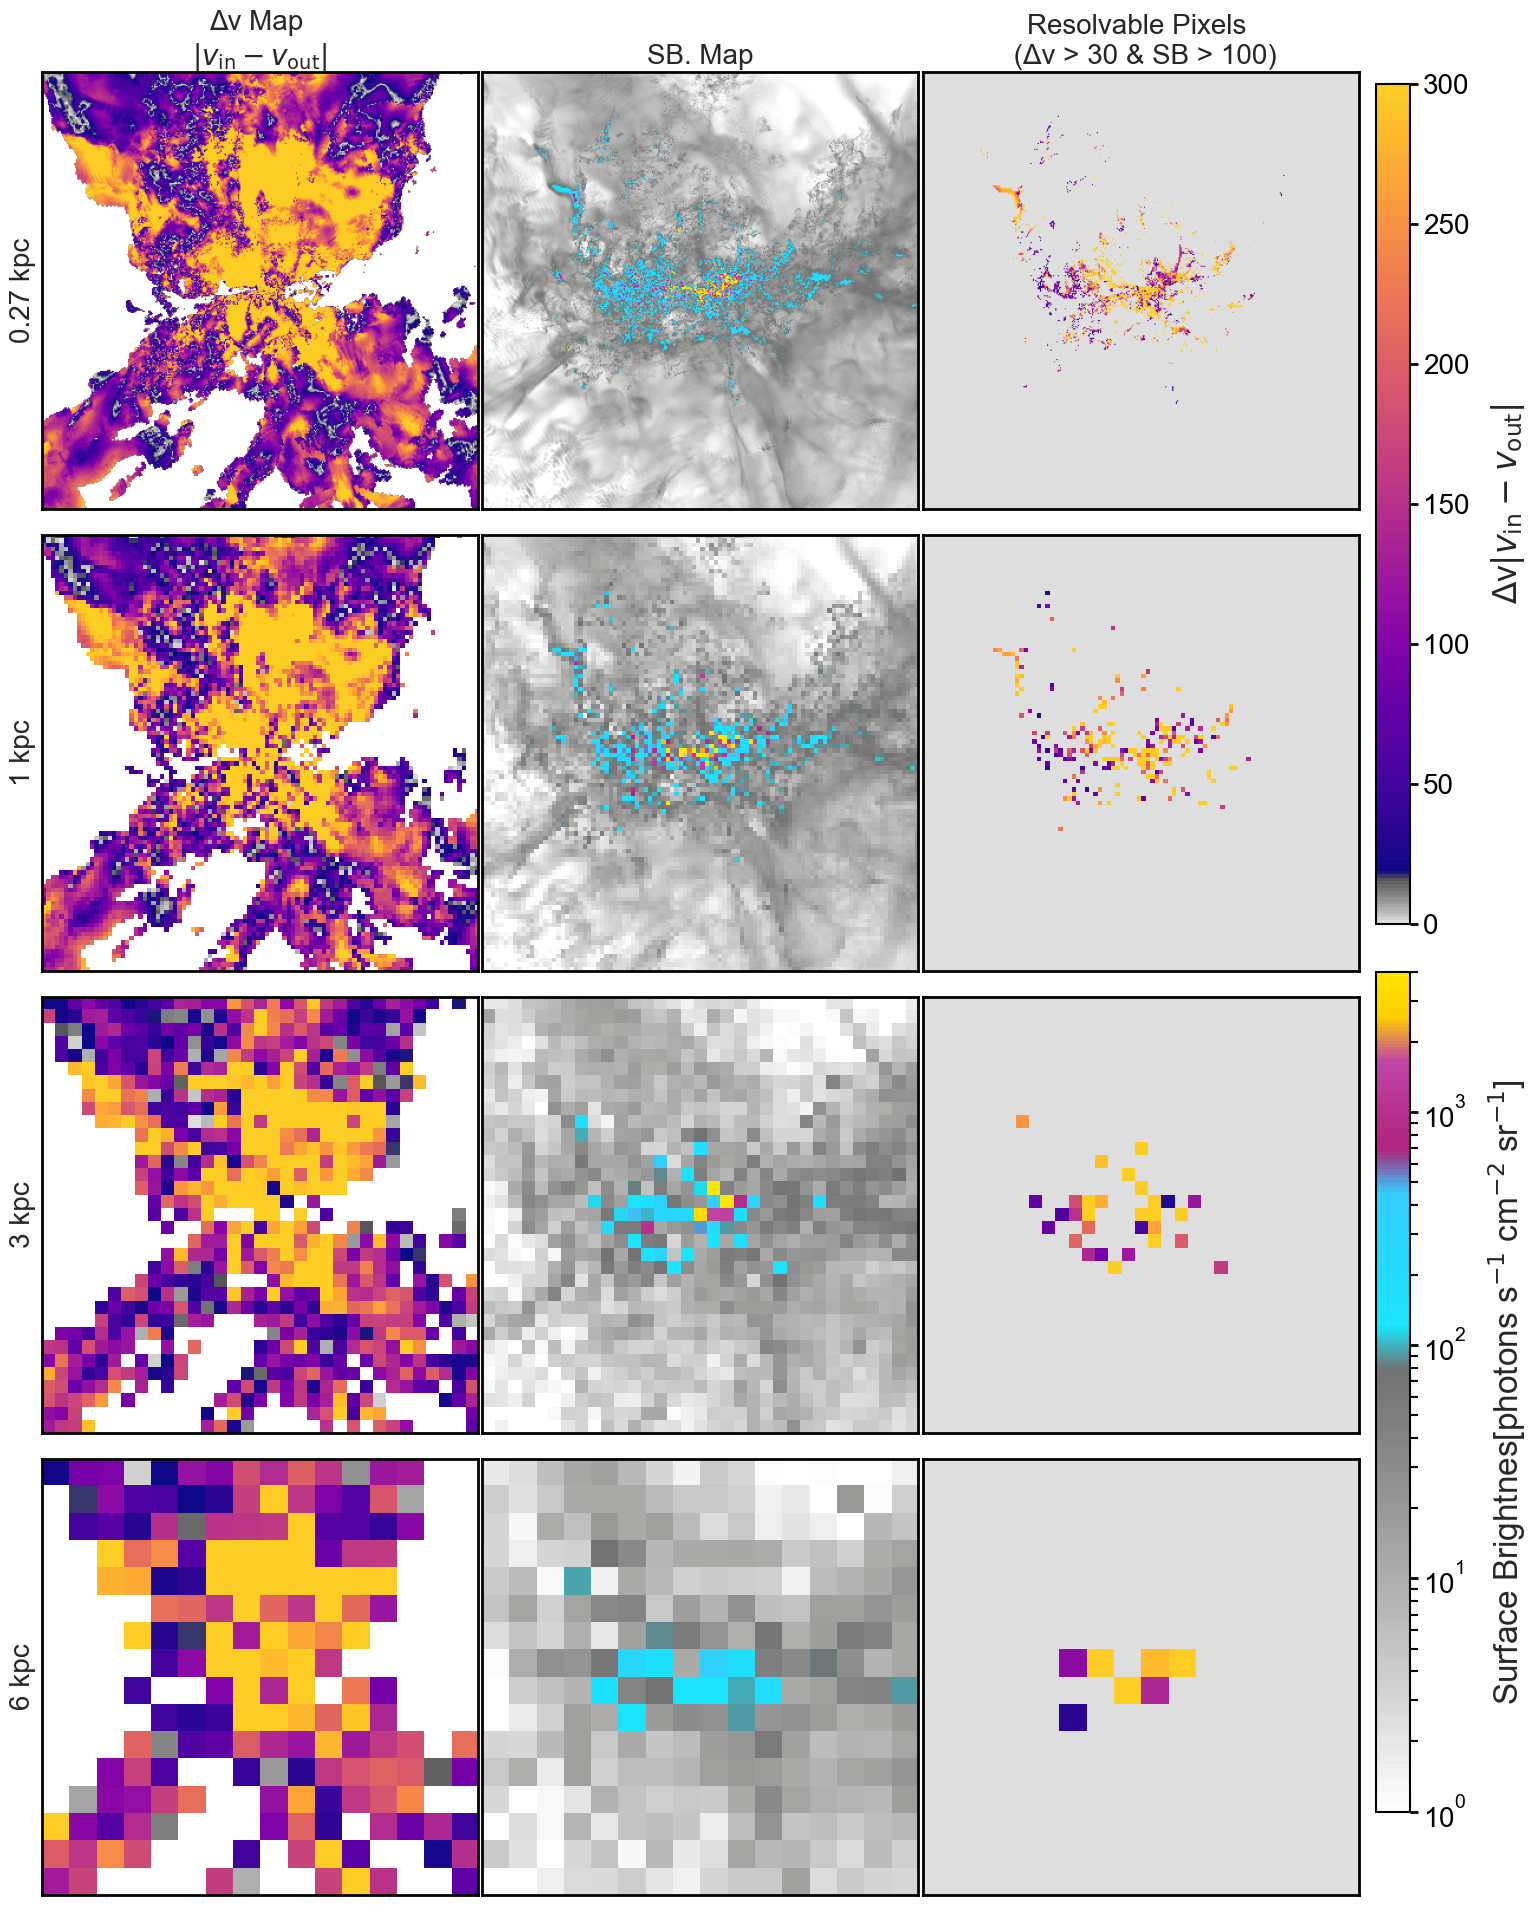

In [83]:
###################################### Talk sample of figure 10 - LOS velocity projections for all ions #####################################

#####################################  Figure 10: velocity and emission map for diff spectral and spatiall resolution ###################################


from collections import defaultdict
results_dict = defaultdict(dict)

plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'


                    # cmap1 = cmr.take_cmap_colors('cmr.viola_r', 3, cmap_range=(0.2, 0.25), return_fmt='rgba')       # >10,000
                    # cmap2 = cmr.take_cmap_colors('autumn', 2, cmap_range=(0.8, 0.9), return_fmt='rgba')    # >1000
                    # cmap3 = cmr.take_cmap_colors('cool', 4, cmap_range=(0.1, 0.2), return_fmt='rgba')       # >100
                    # cmap4 = cmr.take_cmap_colors('cmr.neutral_r', 11, cmap_range=(0.0, 0.5), return_fmt='rgba')    # background

# === Custom emission colormap thresholds ===
cmap_yellow = cmr.take_cmap_colors('cmr.viola_r', 3, cmap_range=(0.2, 0.25), return_fmt='rgba')   # >200
cmap_purple = cmr.take_cmap_colors('autumn', 2, cmap_range=(0.8, 0.9), return_fmt='rgba')         # >10000
cmap_blue   = cmr.take_cmap_colors('cool', 4, cmap_range=(0.1, 0.2), return_fmt='rgba')           # >100
cmap_gray   = cmr.take_cmap_colors('cmr.neutral_r', 11, cmap_range=(0.0, 0.5), return_fmt='rgba') 
#cmr.take_cmap_colors('cmr.neutral_r', 12, cmap_range=(0.5, 0.6), return_fmt='rgba')  # background for talk
cmap_w   = cmr.take_cmap_colors('cmr.neutral_r', 9, cmap_range=(0.0, 0.05), return_fmt='rgba')  # background
cmap_pink = cmr.take_cmap_colors('cmr.flamingo', 1, cmap_range=(0.5, 0.9), return_fmt='rgba') 
combined_cmap = np.hstack([cmap_gray, cmap_blue, cmap_yellow, cmap_purple]) #for paper
#combined_cmap = np.hstack([cmap_w,cmap_gray])#,cmap_pink]) #for my talk

custom_cmap_em = mcolors.LinearSegmentedColormap.from_list('custom_cmap', combined_cmap)
# === Custom velocity colormap thresholds ===
#version1
# cmap_gray   = cmr.take_cmap_colors('cmr.neutral_r', 2, cmap_range=(0.1, 0.5), return_fmt='rgba')  # background
# cmap_red    = cmr.take_cmap_colors('seismic', 4, cmap_range=(0.6, 0.7), return_fmt='rgba')   # bright red
# cmap_green  = cmr.take_cmap_colors('cmr.watermelon', 3, cmap_range=(0.0, 0.2), return_fmt='rgba')      # bright green
# cmap_blue = cmr.take_cmap_colors('winter', 5, cmap_range=(0.1, 0.5), return_fmt='rgba')     
# combined_cmap_dv = np.hstack([cmap_gray, cmap_green, cmap_red, cmap_blue])

#version2
res = 30
vmin, vmax = 0, 500
norm = Normalize(vmin=vmin, vmax=vmax)
frac_below = (res - vmin) / (vmax - vmin)
below_n = int(frac_below * 100)
above_n = 100 - below_n
cmap4 = cmr.take_cmap_colors('cmr.neutral_r', below_n, cmap_range=(0.1, 0.6), return_fmt='rgba')
if res == 300:
    cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.75, 0.9), return_fmt='rgba')
elif res == 200:
    cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.55, 0.9), return_fmt='rgba')
elif res == 100:
    cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.15, 0.9), return_fmt='rgba')
elif res == 30:
    cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.0, 0.9), return_fmt='rgba')
else:
    cmap1 = cmr.take_cmap_colors('plasma', above_n, cmap_range=(0.3, 0.9), return_fmt='rgba')

combined_cmap_dv = cmap4 + cmap1

custom_cmap_dv = mcolors.LinearSegmentedColormap.from_list('custom_cmap_dv', combined_cmap_dv)




# === Thresholds ===
dv_thresh_list = [200,100,30]
sb_thresh_list = [100]#[100,1000,2000]
dv_thresh = 30
sb_thresh = 100

# === Helper function to load emission + delta_v maps ===
def load_maps(file_path_cgm, file_path_io, ion, orientation, region):
    with h5py.File(file_path_cgm, 'r') as f_cgm:
        zgroup = list(f_cgm.keys())[0]
        grp_cgm = f_cgm[zgroup]
        emission = np.array(grp_cgm[f"{ion}_emission_{orientation}_{region}"])

    with h5py.File(file_path_io, 'r') as f_io:
        zgroup = list(f_io.keys())[0]
        grp_io = f_io[zgroup]
        v_in = np.array(grp_io[f"{ion}_vlos_emissweighted_{orientation}_inflow"])
        v_out = np.array(grp_io[f"{ion}_vlos_emissweighted_{orientation}_outflow"])

    # Mask where either inflow or outflow is zero
    valid_mask = (v_in != 0) & (v_out != 0)

    # Build a full 2D delta_v array with NaNs where data is invalid
    delta_v = np.full_like(v_in, np.nan)
    delta_v[valid_mask] = np.abs(v_in[valid_mask] - v_out[valid_mask])

    return emission, delta_v

# === Plotting setup ===
regions = ['all']
halos = ['5036']#,'2392','4123','5016','5036','8508']
ions = ['OVI']
orientations = ['edge']
for dv_thresh in dv_thresh_list:
    for sb_thresh in sb_thresh_list:
        for region in regions:
            print(region)
            for orientation in orientations:
                for halo in halos:
                    halo_name = halo_dict[halo]
                    foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)
                    for ion in ions:
                        #fig, axes = plt.subplots(len(resolutions), 3, figsize=(16, 6 * len(resolutions)))
                        fig = plt.figure(figsize=(17, 6 * len(resolutions)))
                        gs = fig.add_gridspec(len(resolutions), 3, wspace=0.01, hspace=0.001)
                        axes = np.empty((len(resolutions), 3), dtype=object)
                        for i in range(len(resolutions)):
                            for j in range(3):
                                axes[i, j] = fig.add_subplot(gs[i, j])


                        for i, res in enumerate(resolutions):
                            # Construct file paths for current resolution
                            prefix_io = os.path.join(output_dir,'SiII1840', f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                                    f'box_{box_name}', 'inflow_outflow', str(res))
                            file_path_io = os.path.join(prefix_io, 'FRBs', f"{halo_name}_emission_maps.hdf5")
                            if region == 'cgm':
                                prefix_cgm = os.path.join(output_dir,'SiII1840', f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                                        f'box_{box_name}', 'without_disk', str(res), 'disk_cgm')
                                file_path_cgm = os.path.join(prefix_cgm, 'FRBs', f"{halo_name}_emission_maps.hdf5")
                            if region == 'all':
                                prefix_cgm = os.path.join(output_dir,'SiII1840', f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                                        f'box_{box_name}', 'with_disk', str(res))
                                file_path_cgm = os.path.join(prefix_cgm, 'FRBs', f"{halo_name}_emission_maps.hdf5")

                            print(file_path_cgm)
                            
                            # Load maps
                            emission, delta_v = load_maps(file_path_cgm, file_path_io, ion, orientation, region)

                            # --- Column 1: Δv map ---
                            dv_display = delta_v
                            

                            dv_display[delta_v > dv_thresh] = delta_v[delta_v > dv_thresh]
                            ax0 = axes[i, 0]
                            im0 = ax0.imshow(dv_display, origin='lower', cmap=custom_cmap_dv, vmin=0, vmax=300)
                            if i == 0:
                                ax0.set_title(f"Δv Map \n" r"$|v_{\mathrm{in}} - v_{\mathrm{out}}|$", fontsize=20)
                            ax0.set_xticks([])
                            ax0.set_yticks([])
                            ax0.tick_params(left=False, bottom=False)
                            ax0.set_ylabel(f"{res} kpc", fontsize=20)
                            for spine in ax0.spines.values():
                                spine.set_linewidth(2)


                            # --- Column 2: Emission map ---
                            em_display = emission#np.full_like(emission, np.nan)
                            em_display[emission > sb_thresh] = emission[emission > sb_thresh]
                            vmin_em, vmax_em = 1, 4000  
                            ax1 = axes[i, 1]
                            im1 = ax1.imshow(em_display, origin='lower', cmap=custom_cmap_em,norm=LogNorm(vmin=vmin_em, vmax=vmax_em))
                            if i == 0:
                                ax1.set_title("SB. Map", fontsize=20)
                            ax1.set_xticks([])
                            ax1.set_yticks([])
                            ax1.tick_params(left=False, bottom=False)
                            for spine in ax1.spines.values():
                                spine.set_linewidth(2)

                            # --- Column 3: Resolvable pixels (Δv > 100 & SB > 100) ---
                            mask = (emission > sb_thresh) & (delta_v > dv_thresh)
                            display_mask = np.zeros_like(delta_v)
                            display_mask[mask] = delta_v[mask]
                            
                            #
                            total_pixels = np.sum(emission > sb_thresh)#delta_v.size
                            if total_pixels == 0:
                                resolvable_fraction = 0.0  # or np.nan, depending on your preference
                            else:
                                resolvable_pixels = np.sum((emission > sb_thresh) & (delta_v > dv_thresh))
                                resolvable_fraction = (resolvable_pixels / total_pixels) * 100
                            results_dict[(ion, res, dv_thresh, sb_thresh)] = resolvable_fraction

                            #           

                            ax2 = axes[i, 2]
                            
                            im2 = ax2.imshow(display_mask, origin='lower', cmap=custom_cmap_dv, vmin=0, vmax=300)
                            if i == 0:
                                ax2.set_title(f"Resolvable Pixels \n (Δv > {dv_thresh} & SB > {sb_thresh})", fontsize=20)
                            ax2.set_xticks([])
                            ax2.set_yticks([])
                            ax2.tick_params(left=False, bottom=False)
                            for spine in ax2.spines.values():
                                spine.set_linewidth(2)

                        #fig.suptitle(f"{halo_name} - {orientation} - {ion}", fontsize=20, y=0.92)
                        # Shared colorbars
                        cbar_ax2 = fig.add_axes([0.91, 0.15, 0.02, 0.35])
                        cb2 = fig.colorbar(im1, cax=cbar_ax2)
                        cb2.set_label("Surface Brightnes" r'[photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', fontsize=24, labelpad=14)
                        cb2.ax.tick_params(labelsize=20, length=6, width=2)

                        cbar_ax1 = fig.add_axes([0.91, 0.52, 0.02, 0.35])
                        cb1 = fig.colorbar(im0, cax=cbar_ax1)
                        cb1.set_label(f"Δv" r"$|v_{\mathrm{in}} - v_{\mathrm{out}}|$", fontsize=24, labelpad=14)
                        cb1.ax.tick_params(labelsize=20, length=6, width=2)  # Increase tick font and size

    

                        plt.tight_layout()
                        out_dir = os.path.join(output_dir, 'All_halos', 'resolved_dv_em_maps', f'z={z}',f'{orientation}')
                        os.makedirs(out_dir, exist_ok=True)
                        out_file = os.path.join(out_dir, f'cmapv02_{halo_name}_{orientation}_{ion}_dv{dv_thresh}_em{sb_thresh}.png')
                        plt.savefig(out_file, dpi=300, bbox_inches='tight')
                        print(f"Saved figure to {out_file}")
                        plt.show()

                        plt.close()

